# 🔹Step 1: ETL Pipeline Setup & Execution
In this step we import and configure all required libraries and the database connection, implement load_posted_news and load_skipped_news functions to read, deduplicate, and filter new records from JSON into DataFrames, and build the main function to write those new articles into the PostedNews and SkippedNews tables.


#### Part 1: Setup Imports & Database Connection
Import core libraries for JSON handling, data manipulation, database access, visualization, graph analysis, and NLP/ML, then build and instantiate the SQLAlchemy engine for connecting to the CyberNewsBot SQL Server database.

In [6]:
# === Standard Library ===
import json                                 # JSON parsing and serialization
import warnings                             # Suppress or handle library warnings if needed

# === Data Manipulation ===
import pandas as pd                         # Analysis and processing of tabular datasets
import numpy as np                          # Numerical computations and matrix operations

# === Database Connectivity ===
from sqlalchemy import create_engine        # Establish and manage SQL connections
from sqlalchemy.types import NVARCHAR, Date, Time  
                                            # Precise SQL column types for to_sql()

# === Visualization ===
import matplotlib.pyplot as plt             # Core plotting API
import matplotlib.colors as mcolors         # Predefined color palettes and utilities
import matplotlib.cm as cm                  # Colormap registry and mapping functions
from matplotlib.dates import DateFormatter  # Formatting dates on axis
import matplotlib.dates as mdates           # Date locators and formatters
from matplotlib.lines import Line2D         # Custom legend handles
from matplotlib.colors import LogNorm       # Optional: log scale normalization for heatmaps

import seaborn as sns                       # Statistical data visualization built on matplotlib
from wordcloud import WordCloud             # Generating word-cloud visualizations

# === Graph Analysis ===
import networkx as nx                       # Create and analyze graph structures (e.g., topic similarity graphs)

# === Machine Learning / NLP ===
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  
                                            # Text → TF-IDF or term-frequency matrices
from sklearn.cluster import KMeans          # K-Means clustering algorithm
from sklearn.cluster import DBSCAN          # DBSCAN for density-based clustering
from sentence_transformers import SentenceTransformer, util  
                                            # Pretrained transformer embeddings + similarity utilities


In [7]:
# 🛠️ SQL Server connection parameters
server = 'NIKITA-PC'                     # the database server name
database = 'CyberNewsBot'                # the target database name
driver = 'ODBC Driver 17 for SQL Server' # the ODBC driver to use for the connection

# Build the SQLAlchemy connection string
connection_string = (
    f"mssql+pyodbc://@{server}/{database}"              # protocol + server + database
    f"?driver={driver.replace(' ', '+')}&Trusted_Connection=yes"
)
engine = create_engine(connection_string)  # create the SQLAlchemy engine for executing queries


#### Part 2: `load_posted_news` Function  
ETL routine for reading and filtering successful articles (`PostedNews`):  
1. Read `posted_news_ud.json` into a DataFrame.  
2. Convert the `keywords` column from a list into a comma-separated string.  
3. Execute an SQL query to fetch all existing `text_hash` values.  
4. Filter out already-loaded records and apply `drop_duplicates` on `text_hash`.


In [8]:
def load_posted_news(engine, json_path: str = "posted_news_ud.json") -> pd.DataFrame:
    df = pd.read_json(json_path) 
    # Read the JSON file into a pandas DataFrame
    
    if 'keywords' in df.columns: 
        df['keywords'] = df['keywords'].str.join(',')
        
    existing = pd.read_sql("SELECT text_hash FROM PostedNews", con=engine) 
    #Query the database for all text_hash values already in PostedNews
    
    mask = ~df['text_hash'].isin(existing['text_hash'])  
    #Create a boolean mask marking only rows whose text_hash is not yet in the database
    
    new_df = df.loc[mask]  
    #Apply the mask to filter the DataFrame
    
    new_df = new_df.drop_duplicates(subset=['text_hash']).copy()  
    #Remove any duplicate rows based on text_hash, then make a copy to avoid warnings
    
    return new_df
    # Return the cleaned DataFrame of new articles


#### Part 3: `load_skipped_news` Function  
ETL routine for reading and filtering skipped articles (`SkippedNews`):  
1. Load `skipped_news_ud.json` as a Python dict and convert to a DataFrame.  
2. Remove the redundant `date` column.  
3. Execute an SQL query to fetch all existing `text_hash` values.  
4. Filter out already-loaded records and apply `drop_duplicates` on `text_hash`.

In [9]:
def load_skipped_news(engine, json_path: str = "skipped_news_ud.json") -> pd.DataFrame:
    with open(json_path, encoding='utf-8') as f:
        data = json.load(f)  
        # Load the JSON file into a Python dict

    df = pd.DataFrame(list(data.values())) 
    # Convert the dict values into a pandas DataFrame

    if 'date' in df.columns: # If there is an unused 'date' column, drop it
        df = df.drop(columns=['date'])

    existing = pd.read_sql("SELECT text_hash FROM SkippedNews", con=engine) 
    # Query the database for all text_hash values already in SkippedNews

    mask = ~df['text_hash'].isin(existing['text_hash']) 
    # Create a boolean mask for records not yet in the database

    new_df = df.loc[mask].drop_duplicates(subset=['text_hash']).copy()  
    # Filter the DataFrame by the mask and drop any duplicates by text_hash

    return new_df  
    # Return the cleaned DataFrame of new skipped entries

#### Part 4: `main` Function to Execute the ETL  
1. Call `load_posted_news` and write the new records to the `PostedNews` table.  
2. Call `load_skipped_news` and write the new records to the `SkippedNews` table.  
3. Print status messages and display 5 sample article titles from each table.  

In [10]:
def main():
    # ——— Step 1: Load PostedNews ———
    posted = load_posted_news(engine)  
    # Call the ETL function to get new posted articles

    if not posted.empty:  
        # If there are new articles, append them to the PostedNews table
        posted.to_sql(
            "PostedNews",                 
            con=engine,
            if_exists="append",            
            index=False,                   
            chunksize=1000,                
            dtype={                        
                'published_date': Date(),  
                'published_time': Time(),  
                'keywords': NVARCHAR(length=None)  
            }
        )
        print(f"✅ Loaded {len(posted)} new articles to PostedNews.")
        print("Sample titles loaded into PostedNews:")
        for title in posted['title'].head(5):  
            print(f"  - {title}")
    else:
        print("ℹ️ No new articles to load into PostedNews.")

    # ——— Step 2: Load SkippedNews ———
    skipped = load_skipped_news(engine)  
    # Call the ETL function to get new skipped articles

    if not skipped.empty:  
        # If there are new entries, append them to the SkippedNews table
        skipped.to_sql(
            "SkippedNews",                 
            con=engine,
            if_exists="append",
            index=False,
            chunksize=1000,
            dtype={
                'published_date': Date(),  
                'published_time': Time(),  
                'reason': NVARCHAR(length=300)  
            }
        )
        print(f"✅ Loaded {len(skipped)} new entries to SkippedNews.")
        print("Sample titles loaded into SkippedNews:")
        for title in skipped['title'].head(5):
            print(f"  - {title}")
    else:
        print("ℹ️ No new entries to load into SkippedNews.")

if __name__ == "__main__":
    main()  
    # When this script is executed directly, run the main() function

✅ Loaded 4829 new articles to PostedNews.
Sample titles loaded into PostedNews:
  - R Street report examines open-source AI cyber risks, calls for federal guidelines
  - CISA, DHS, INL host LSU to strengthen cyber defense training across critical infrastructure sector
  - Cowbell introduces Prime One Tech in the UK to support cyber and PI needs of growing tech sector
  - FBI: Cybercrime cost victims 'staggering' $16.6B last year - The Register
  - Cowbell Launches New Professional Indemnity Offering for UK Tech Firms
✅ Loaded 1513 new entries to SkippedNews.
Sample titles loaded into SkippedNews:
  - पुण्यात बनावट कॉल सेंटरचा भंडाफोड, 100 पेक्षा अधिक जण ताब्यात | Pune Cyber Crime - YouTube
  - Undocumented Communication Devices Found in Chinese Solar Tech Spark U.S. Security Concerns
  - Tech coalition to push for faster US foreign cybersecurity aid - Digital Watch Observatory
  - Cyber support center set up in Jaipur to strengthen cybersecurity - MSN
  - IT Security News Daily Summary

# 🔹Step 2: Exploratory Data Analysis & Key Visualizations
In this step we load and inspect the PostedNews and SkippedNews tables, engineer date/time and keyword features, create a donut chart of the top keywords, and produce five core visualizations—combined success vs failure trends, daily growth rates, failure reason distribution, country-level published vs skipped comparisons, and a heatmap of failures by reason and date.

#### Part 1: Data Retrieval & Initial Inspection  
In this section we load the `PostedNews` and `SkippedNews` tables into pandas DataFrames and perform basic exploratory checks: dimensions, duplicate counts, column info, missing values, descriptive statistics, unique counts, random samples, and date distribution.


In [11]:
# Retrieving tables from SQL into DataFrames
posted_df = pd.read_sql("SELECT * FROM PostedNews ORDER BY ID", con=engine)  
skipped_df = pd.read_sql("SELECT * FROM SkippedNews ORDER BY ID", con=engine)

# --- PostedNews basic checks ---
print("=== POSTED DF SHAPE ===", posted_df.shape)             
# How many rows and columns

print("=== POSTED DUPLICATES ===", posted_df.duplicated().sum())  
# Total duplicate rows

print("Duplicates by title:", posted_df['title'].duplicated().sum())      
print("Duplicates by url:", posted_df['url'].duplicated().sum())          
print("Duplicates by text_hash:", posted_df['text_hash'].duplicated().sum())  
# Duplicate counts for key columns

print("=== POSTED COLUMNS ===", posted_df.columns.tolist())  
# List of column names

print("=== POSTED NULLS ===\n", posted_df.isnull().sum())  
# Count of missing values per column

print("=== POSTED INFO ===")  
posted_df.info()  
# DataFrame info: dtype, non-null counts

print("=== POSTED DESCRIBE ===\n", posted_df.describe(include='all'))  
# Descriptive statistics for all columns

print("\nNumber of unique values for each column:")
print(posted_df.nunique())  
# Unique value counts per column

print("\nRandom sample from posted_df:")
print(posted_df.sample(5))  
# Display 5 random rows

print("\nSort articles by date:")
print(posted_df['published_date'].value_counts().sort_index())  
# Frequency of articles per date, sorted chronologically

# --- SkippedNews basic checks ---
print("=== SKIPPED DF SHAPE ===", skipped_df.shape)             
print("=== SKIPPED DUPLICATES ===", skipped_df.duplicated().sum())
print("Duplicates by title:", skipped_df['title'].duplicated().sum())
print("Duplicates by url:", skipped_df['url'].duplicated().sum())
print("Duplicates by text_hash:", skipped_df['text_hash'].duplicated().sum())

print("=== SKIPPED COLUMNS ===", skipped_df.columns.tolist())
print("=== SKIPPED NULLS ===\n", skipped_df.isnull().sum())
print("=== SKIPPED INFO ===")
skipped_df.info()

print("=== SKIPPED DESCRIBE ===\n", skipped_df.describe(include='all'))
print("\nNumber of unique values for each column:")
print(skipped_df.nunique())

print("\nRandom sample from skipped_df:")
print(skipped_df.sample(5))

print("\nSort articles by date:")
print(skipped_df['published_date'].value_counts().sort_index())


=== POSTED DF SHAPE === (4829, 10)
=== POSTED DUPLICATES === 0
Duplicates by title: 0
Duplicates by url: 0
Duplicates by text_hash: 0
=== POSTED COLUMNS === ['ID', 'title', 'url', 'text_hash', 'summary', 'source', 'published_date', 'published_time', 'rss_source', 'keywords']
=== POSTED NULLS ===
 ID                0
title             0
url               0
text_hash         0
summary           0
source            0
published_date    0
published_time    0
rss_source        0
keywords          0
dtype: int64
=== POSTED INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829 entries, 0 to 4828
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4829 non-null   int64 
 1   title           4829 non-null   object
 2   url             4829 non-null   object
 3   text_hash       4829 non-null   object
 4   summary         4829 non-null   object
 5   source          4829 non-null   object
 6   publi

#### Part 2: Date & Time Conversion and Feature Engineering
In this section we standardize date/time columns and create auxiliary features (`day_of_week`, `hour`) for both DataFrames.

In [12]:
# Parse published_date as datetime, coercing invalid formats to NaT
posted_df['published_date'] = pd.to_datetime(
    posted_df['published_date'], errors='coerce'
)

# Parse published_time as time objects, then extract .hour
posted_df['published_time'] = pd.to_datetime(
    posted_df['published_time'], format='%H:%M:%S', errors='coerce'
).dt.time

# Repeat for skipped_df
skipped_df['published_date'] = pd.to_datetime(
    skipped_df['published_date'], errors='coerce'
)
skipped_df['published_time'] = pd.to_datetime(
    skipped_df['published_time'], format='%H:%M:%S', errors='coerce'
).dt.time

# Feature: day of week
posted_df['day_of_week'] = posted_df['published_date'].dt.day_name()
skipped_df['day_of_week'] = skipped_df['published_date'].dt.day_name()

# Feature: hour of day
posted_df['hour'] = pd.to_datetime(posted_df['published_time'], errors='coerce').dt.hour
skipped_df['hour'] = pd.to_datetime(skipped_df['published_time'], errors='coerce').dt.hour

# Aggregate counts per date for comparison
daily_sent = posted_df['published_date'].value_counts().sort_index()
daily_skipped = skipped_df['published_date'].value_counts().sort_index()

# Combine into a single DataFrame for side-by-side comparison
comparison_df = pd.DataFrame({'Sent': daily_sent,'Skipped': daily_skipped}).fillna(0).astype(int)

print("\nDaily breakdown of articles sent vs. failed:")
print(comparison_df)



Daily breakdown of articles sent vs. failed:
                Sent  Skipped
published_date               
2025-04-23        40        0
2025-04-24       132        0
2025-04-25       118        0
2025-04-26        83        0
2025-04-27        59        0
2025-04-28       190        0
2025-04-29       145        0
2025-04-30       129        0
2025-05-01        99        0
2025-05-02       110        0
2025-05-03        66        0
2025-05-04        63        0
2025-05-05       117        0
2025-05-06       125        0
2025-05-07        64        0
2025-05-08        95        0
2025-05-09       108        0
2025-05-10        81        0
2025-05-11        58        0
2025-05-12       133        0
2025-05-13       130        0
2025-05-14       136        0
2025-05-15       153        0
2025-05-16       122        0
2025-05-17        49        0
2025-05-18        73        0
2025-05-19       150        0
2025-05-20       156        0
2025-05-21       127        0
2025-05-22       123    

####  Part 3: Keyword Cleaning & Extraction
Remove common stopwords from each article’s raw keyword list to create a cleaned_keywords column, calculate the average keywords per article, and identify the top 10 most frequent keywords across all published articles.


In [13]:
#Stopwords and keyword cleaning
#Create a cleaned_keywords column

stopwords = {
    "the", "a", "an", "and", "or", "with", "by", "from", "after", "against", "company", "their", "its", "on",
    "for", "in", "of", "to", "is", "are", "was", "as", "this", "that", "these", "those", "about", "into",
    "platform", "portal", "manage", "known", "primarily", "better", "current", "systems"
}

def clean_keywords(keyword_str):
    return [
        word.strip().lower()
        for word in str(keyword_str).split(',')
        if word.strip().lower() and word.strip().lower() not in stopwords
    ]

posted_df['cleaned_keywords'] = posted_df['keywords'].apply(clean_keywords)

#Average keywords per article
avg_keywords_per_article = posted_df['cleaned_keywords'].apply(len).mean()
print(f"Average number of keywords per article: {avg_keywords_per_article:.2f}")


def get_top_keywords(df, column: str, top_n: int = 10) -> pd.DataFrame:
    return ( df[column].explode().value_counts().nlargest(top_n).rename_axis('keyword').reset_index(name='count').astype({'count': int}))

# Usage
top10 = get_top_keywords(posted_df, 'cleaned_keywords', top_n=10)
print("Top 10 Keywords:")
print(top10.to_string(index=False))


Average number of keywords per article: 4.89
Top 10 Keywords:
      keyword  count
        cyber   1981
     security    819
cybersecurity    596
       attack    237
  information    144
     national    142
        marks    136
      spencer    126
      threats    125
      attacks    103


#### 🔸Donut Chart of Top Keywords  
In this section we visualize the relative frequency share of the top 8 keywords using a pie chart.

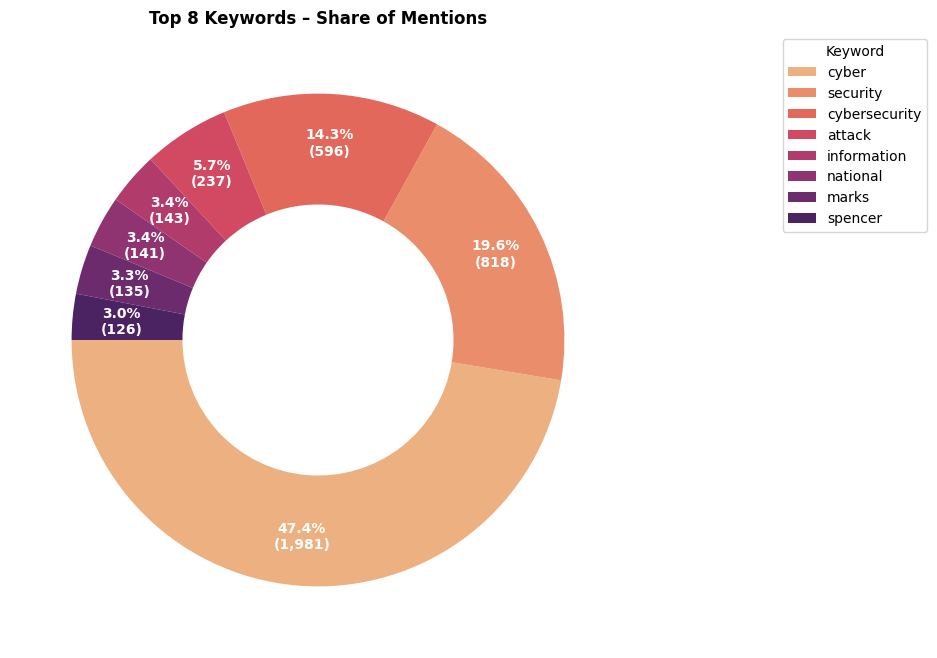

In [14]:
def plot_top_keywords_pie(df, top_n=8,
                          figsize=(8, 8),
                          cmap_name="flare",
                          donut=True):

    # 1) Aggregate & sort
    top = (get_top_keywords(df, 'cleaned_keywords', top_n).sort_values('count', ascending=False).reset_index(drop=True))

    labels = top['keyword']
    sizes  = top['count']
    total  = sizes.sum()

    # 2) Build colour list out of the chosen colormap
    cmap   = plt.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, len(labels)))

    # 3) Create the figure & axes (equal aspect keeps the pie round)
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))

    # 4) Draw the wedges
    wedgeprops = dict(width=0.45) if donut else None   # width<1 → donut
    
    wedges, texts, autotexts = ax.pie(
        
        sizes,
        colors=colors,
        startangle=180,              # rotate so the largest slice starts at 140°
        autopct=lambda pct:
            f"{pct:.1f}%\n({int(pct/100.*total):,})",  # show % + absolute
        pctdistance=0.8 if donut else 0.6,             # text position
        textprops=dict(color="white", weight="bold",fontsize=10),
        wedgeprops=wedgeprops
    )

    # 5) Legend on the right
    ax.legend(wedges, labels, title="Keyword",loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

    # 6) Title
    ax.set_title(f"Top {top_n} Keywords – Share of Mentions", weight="bold")
    return fig, ax

fig, ax = plot_top_keywords_pie(posted_df, top_n=8)
plt.show()



####  Part 4: Time Series & Aggregations (5 Graphs) 
Daily and Country-Level Article Publication and Failure Statistics

In [42]:
#Total articles published by date
articles_per_day = posted_df.groupby('published_date').size()
#Total failed articles by date
failures_per_day = skipped_df.groupby('published_date').size()

#Total articles published And not published by country
posted_per_country = posted_df['rss_source'].value_counts().rename('Published')
skipped_per_country = skipped_df['rss_source'].value_counts().rename('Skipped')

#Failure reasons by date
failures_by_reason_date = skipped_df.groupby(['published_date', 'reason']).size().unstack(fill_value=0)

#### 🔸Graph 1: Combined comparison graph of successes versus failures

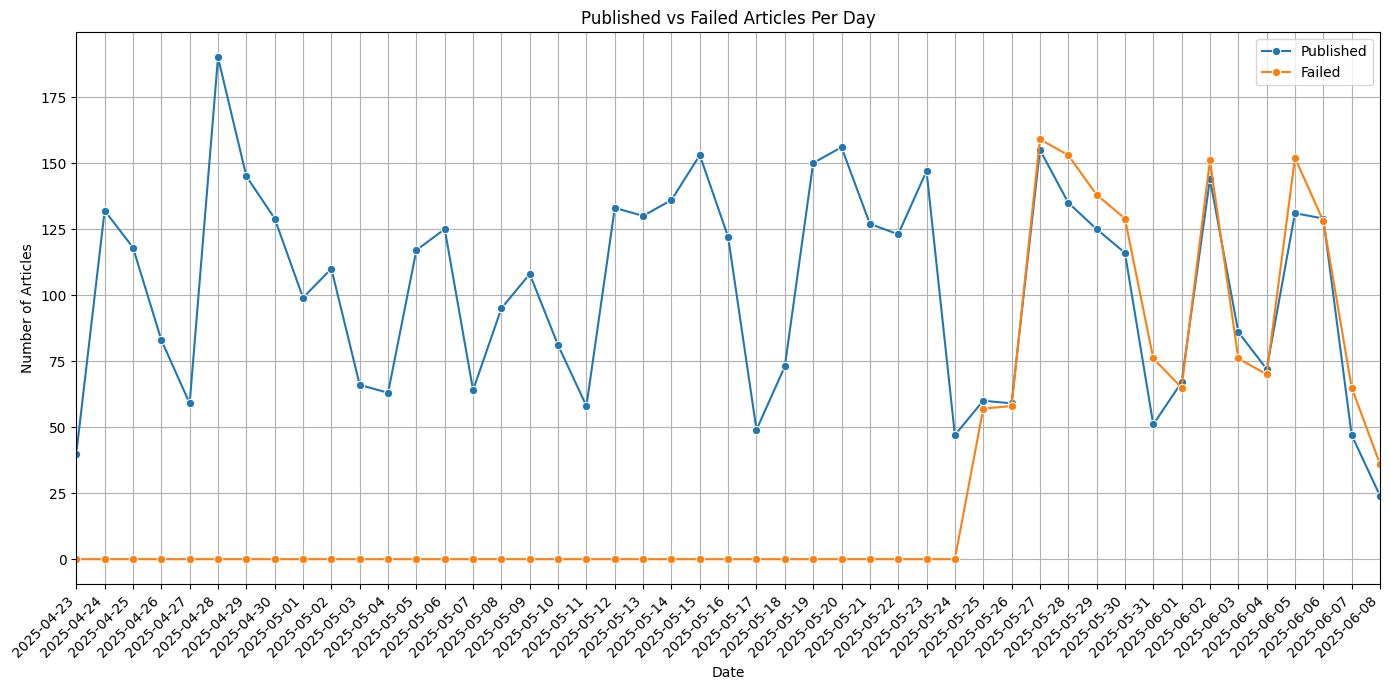

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Step 1: Combine published & failed counts into one DataFrame
combined_df = pd.concat([
    articles_per_day.rename('Published'),
    failures_per_day.rename('Failed')
], axis=1).fillna(0)

# Reset index to turn the dates into a column
ts_df = combined_df.reset_index().rename(columns={'index': 'published_date'})

# Step 2: Create the line plot
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(
    data=ts_df,
    x='published_date',
    y='Published',
    marker='o',
    label='Published',
    ax=ax
)
sns.lineplot(
    data=ts_df,
    x='published_date',
    y='Failed',
    marker='o',
    label='Failed',
    ax=ax
)

# Step 3: Force the x-axis to cover the entire date range (including the last date)
ax.set_xlim(
    ts_df['published_date'].min(),
    ts_df['published_date'].max()
)

# Step 4: Show every single date tick on the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))   # one tick per day
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))     # format as YYYY-MM-DD
fig.autofmt_xdate(rotation=45)                              # rotate labels for readability

# Step 5: Final touches
ax.set_title('Published vs Failed Articles Per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Articles')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


#### 🔸Graph 2: Daily Growth Rate in Published Articles

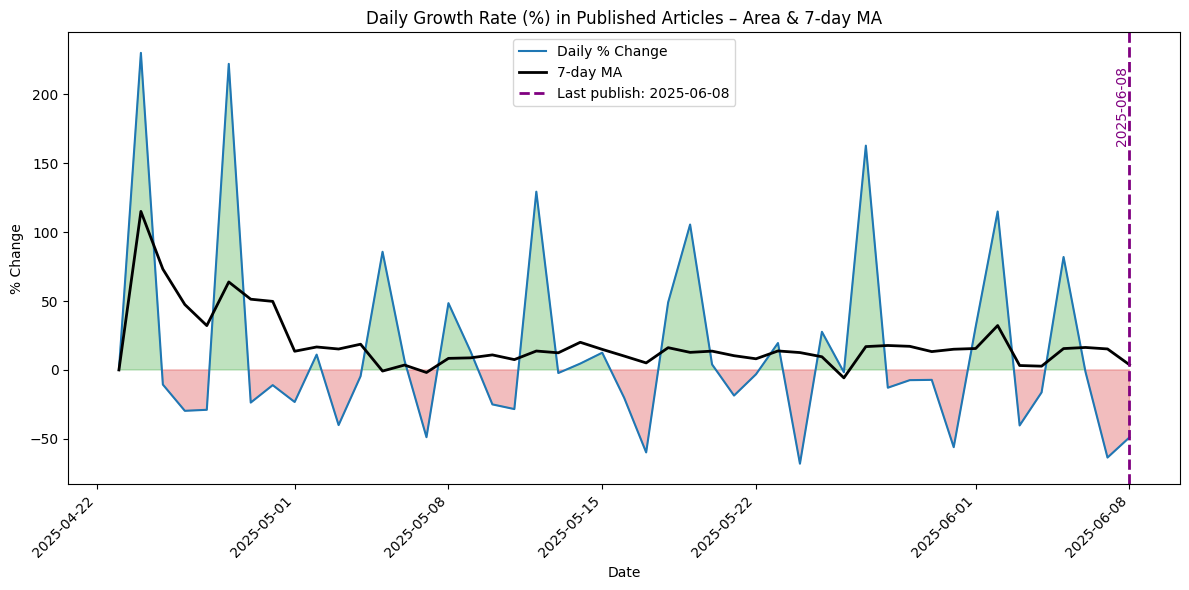

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Step 1: Prepare DataFrame
# — compute daily % change and reset index for plotting
growth = articles_per_day.pct_change().fillna(0) * 100
df_growth = growth.reset_index().rename(columns={
    'published_date': 'date',
    0: 'pct_change'
})

# Step 2: Calculate 7-day rolling average
# — for each day, average that day + previous 6 days (min_periods=1 allows early days)
df_growth['rolling'] = df_growth['pct_change'].rolling(window=7, min_periods=1)\
    .mean()

# Step 3: Identify the last publish date
# — pick the last index where at least one article was published
last_pub_date = articles_per_day[articles_per_day > 0].last_valid_index()

# Step 4: Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# 4a) Plot daily % change line
sns.lineplot(data=df_growth, x='date', y='pct_change',color='tab:blue', label='Daily % Change', ax=ax
)

# 4b) Fill areas: green when positive, red when negative
ax.fill_between(
    df_growth['date'], df_growth['pct_change'], 0,
    where=(df_growth['pct_change'] >= 0),
    interpolate=True, color='tab:green', alpha=0.3
)

ax.fill_between(
    df_growth['date'], df_growth['pct_change'], 0,
    where=(df_growth['pct_change'] < 0),
    interpolate=True, color='tab:red', alpha=0.3
)

# 4c) Plot the 7-day moving average
sns.lineplot(
    data=df_growth, x='date', y='rolling',
    color='black', linewidth=2, label='7-day MA', ax=ax
)

# Step 5: Mark the last publish date
# — vertical dashed line
ax.axvline(
    last_pub_date, color='purple', linestyle='--', linewidth=2,
    label=f'Last publish: {last_pub_date.strftime("%Y-%m-%d")}'
)
# — text annotation next to the line
y_max = ax.get_ylim()[1]
ax.text(
    last_pub_date, y_max * 0.9,
    last_pub_date.strftime('%Y-%m-%d'),
    rotation=90, color='purple', va='top', ha='right'
)

# Step 6: Final formatting
ax.set_title('Daily Growth Rate (%) in Published Articles – Area & 7-day MA')
ax.set_xlabel('Date')
ax.set_ylabel('% Change')
ax.legend()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()


#### 🔸Graph 3: Percentage Distribution of Failure Reasons

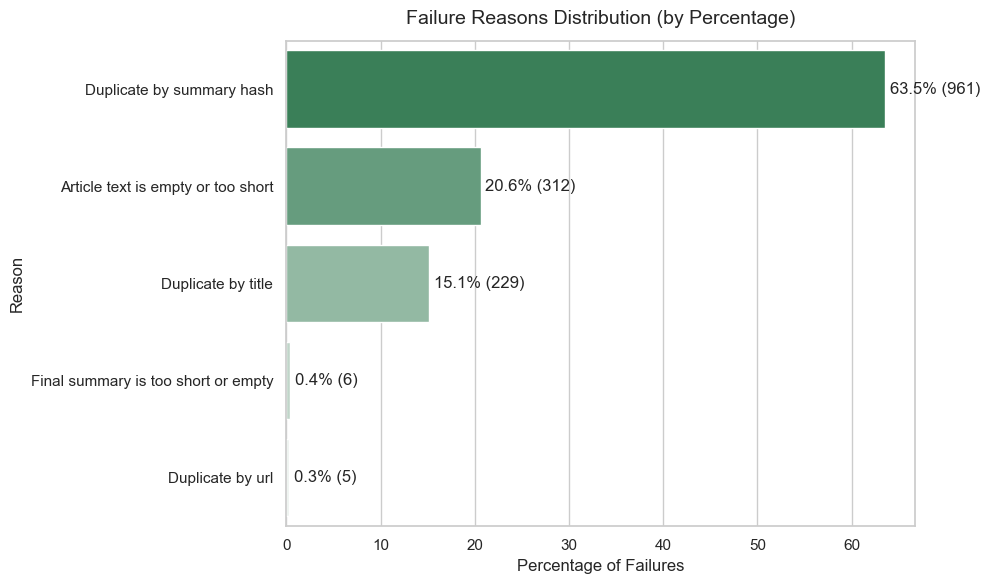

In [18]:
reason_counts = (
    skipped_df['reason']
    .value_counts()                       # count occurrences of each reason
    .rename_axis('reason')                # name the index “reason”
    .reset_index(name='count')            # turn into DataFrame with columns ['reason','count']
)

total = reason_counts['count'].sum()     # sum of all failure counts
reason_counts['pct'] = (                # add a new column 'pct'
    reason_counts['count'] / total * 100  # percentage share of each reason
)

sns.set_theme(style="whitegrid")          # set a clean background with grid lines
fig, ax = plt.subplots(figsize=(10, 6))  # create figure and axes, size in inches

sns.barplot(
    data=reason_counts,                   # supply the DataFrame
    y='reason',                           # plot reasons along the y-axis (horizontal bars)
    x='pct',                              # length of bars = percentage values
    hue='reason',                         # use the 'reason' column to map colors
    palette=sns.light_palette("seagreen", n_colors=len(reason_counts), reverse=True),
    dodge=False,                          # do not separate bars by hue categories
    ax=ax                                 # draw on our axes
)

if ax.get_legend() is not None:
    ax.get_legend().remove()

# Annotate each bar with “xx.x% (nnn)” to show both percentage and raw count
for i, row in reason_counts.iterrows():
    ax.text(
        row['pct'] + 0.5,                 # x-coordinate: slightly to the right of bar end
        i,                                 # y-coordinate: same as bar index
        f"{row['pct']:.1f}% ({row['count']})",  # text label
        va='center'                       # vertical alignment: center on the bar
    )

# Final formatting: titles and axis labels
ax.set_title('Failure Reasons Distribution (by Percentage)', fontsize=14, pad=12)
ax.set_xlabel('Percentage of Failures', fontsize=12)
ax.set_ylabel('Reason', fontsize=12)
plt.tight_layout()                       # adjust subplots to fit in the figure area
plt.show()                               # display the plot


####  🔸Graph 4: Published vs Skipped Articles by Country

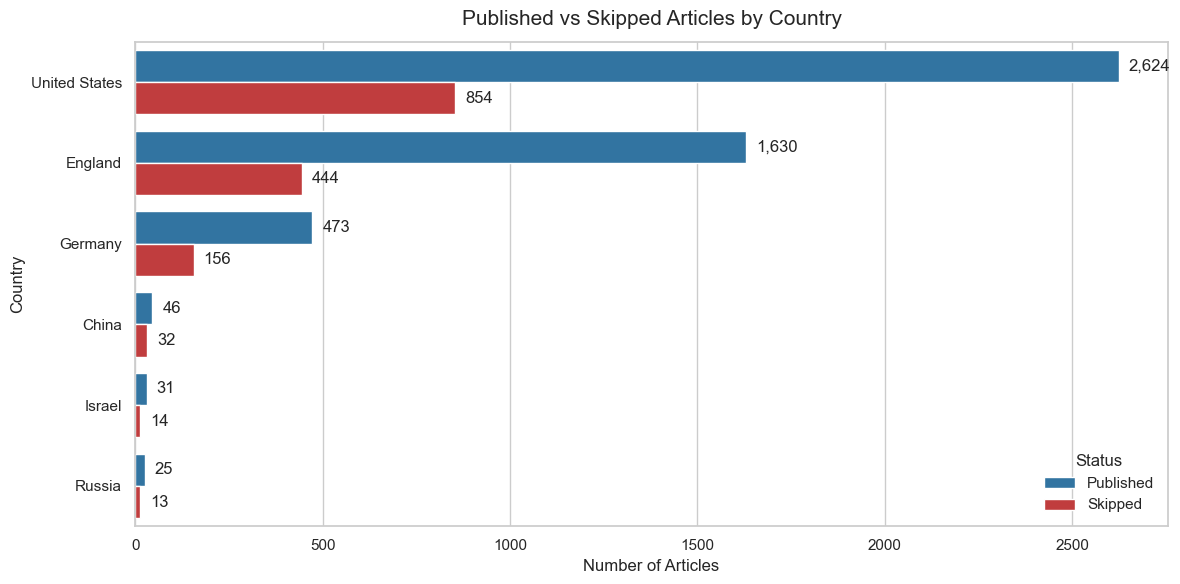

In [19]:
# Join the two series → wide table
country_wide = pd.concat([posted_per_country, skipped_per_country], axis=1).fillna(0).astype(int)

# Keep only countries that have at least one article (either status)
country_wide = country_wide.loc[country_wide.sum(axis=1) > 0]

# Convert to “long” format for seaborn
country_long = (
    country_wide
    .sort_values('Published', ascending=False)      # order by Published
    .reset_index(names='country')                  # move index to column
    .melt(id_vars='country',                       # -> columns: country | status | count
          var_name='status',
          value_name='count')
)

# Plot grouped horizontal bars
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))

# Custom palette: Published = blue, Skipped = red
palette = {'Published': 'tab:blue', 'Skipped': 'tab:red'}

sns.barplot(
    data=country_long,
    y='country', x='count',
    hue='status',            # now hue distinguishes Published vs Skipped
    palette=palette,
    dodge=True,              # side-by-side bars (horizontal grouping)
    ax=ax
)

# Annotate each bar (skip bars with width == 0)
for p in ax.patches:
    width = p.get_width()
    if width == 0:       # לא להדפיס טקסט על בר “ריק”
        continue
    ypos = p.get_y() + p.get_height() / 2
    ax.text(
        width + country_long['count'].max() * 0.01,
        ypos,
        f'{int(width):,}',
        va='center'
    )

ax.set_title('Published vs Skipped Articles by Country', fontsize=15, pad=12)
ax.set_xlabel('Number of Articles', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.legend(title='Status', frameon=False)
plt.tight_layout()
plt.show()


####  🔸Graph 5: Heatmap – Failure Reason by Date


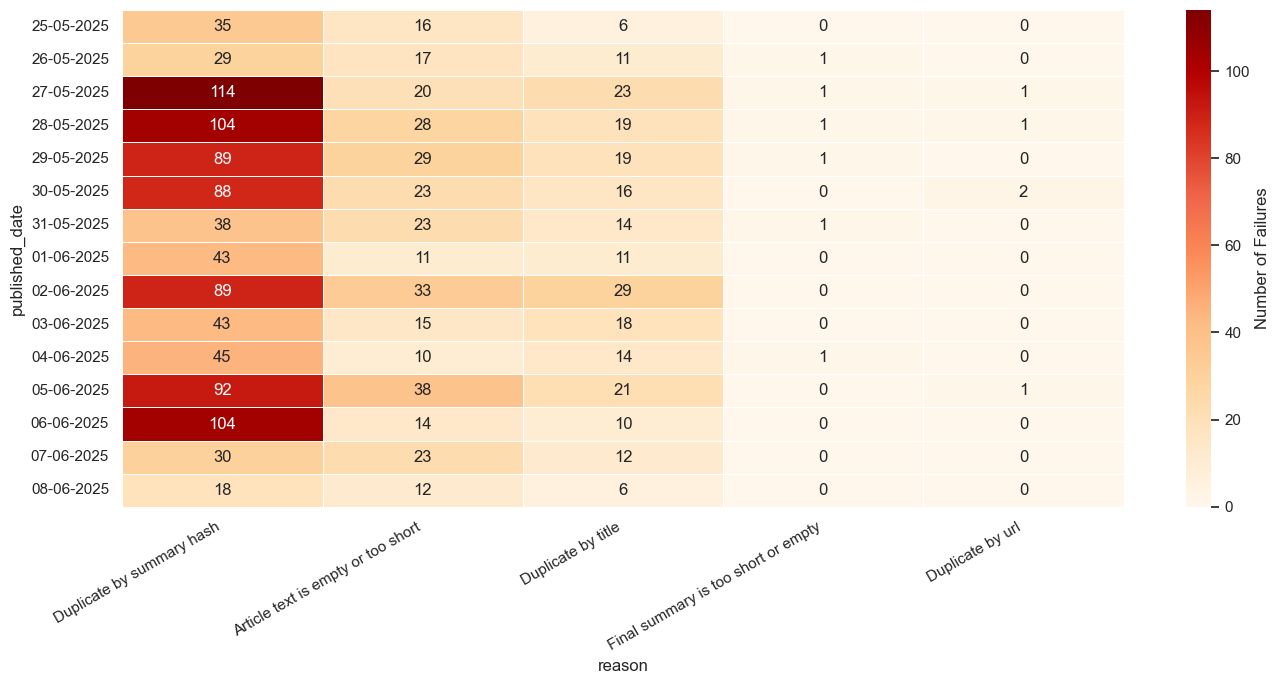

In [20]:
order = failures_by_reason_date.sum(axis=0).sort_values(ascending=False).index
heat_data = failures_by_reason_date[order]
heat_data.index = heat_data.index.strftime('%d-%m-%Y')

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(
    heat_data,
    cmap="OrRd",
    annot=True, fmt='d',
    linewidths=.5, linecolor='white',
    yticklabels=heat_data.index,            # index כבר מחרוזות
    cbar_kws={"label": "Number of Failures"},
    ax=ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.show()



# 🔹Step 3: Duplicate Detection & Hourly Publication Flow
In this step we pinpoint the most frequent duplicate articles—by title, summary hash, and URL—and then build and visualize the hourly flow of published versus duplicate articles over the past week using a bubble‐size scatter plot.


#### part 1: Identifying Top Duplicates by Title, Summary Hash, and URL
In this part we compute and display the top duplicate articles in three categories—by title, by summary hash, and by URL—to highlight the most frequent sources of duplication.

In [21]:
# PARAMETERS
MIN_DUP   = 1
TOP_N     = 5
TITLE_REASON = 'Duplicate by title'
HASH_REASON  = 'Duplicate by summary hash'
URL_REASON  = 'Duplicate by url'

def show_top_dupes(df_posted: pd.DataFrame,
                   df_skipped: pd.DataFrame,
                   reason: str,
                   count_col_out: str,
                   key_col: str,
                   min_dup: int = 2,
                   top_n: int = 10) -> pd.DataFrame:
  
    # count how many skipped per key
    counts = (df_skipped[df_skipped['reason'] == reason].groupby(key_col).size())
    total_dup_in_skipped = counts.sum()

    # map counts back to posted dataframe
    df_posted[count_col_out] = (
        df_posted[key_col].map(counts).fillna(0).astype(int)
    )

    # filter only rows with at least min_dup duplicates
    noisy = df_posted[df_posted[count_col_out] >= min_dup]

    # add percentage column
    noisy = (noisy[['title', count_col_out]].assign(
            perc_of_reason=lambda x: (x[count_col_out] / total_dup_in_skipped * 100).round(1))
             
        .sort_values(count_col_out, ascending=False)
        .head(top_n)
    )

    
    # 5️⃣ pretty print
    print(f"\n► {reason} — Top {top_n} (≥{min_dup} duplicates)")
    print(noisy.to_string(index=False))

    return noisy

# RUN for title duplicates
top_title_dupes = show_top_dupes(
    posted_df.copy(),
    skipped_df,
    reason=TITLE_REASON,
    count_col_out='dup_titles',
    key_col='title',
    min_dup=MIN_DUP,
    top_n=TOP_N
)

# RUN for summary-hash duplicates
top_hash_dupes = show_top_dupes(
    posted_df.copy(),
    skipped_df,
    reason=HASH_REASON,
    count_col_out='dup_hashes',
    key_col='text_hash',
    min_dup=MIN_DUP,
    top_n=TOP_N
)

# RUN for summary-url duplicates
top_hash_dupes = show_top_dupes(
    posted_df.copy(),
    skipped_df,
    reason=URL_REASON,
    count_col_out='dup_url',
    key_col='url',
    min_dup=MIN_DUP,
    top_n=TOP_N
)



► Duplicate by title — Top 5 (≥1 duplicates)
                                                                                       title  dup_titles  perc_of_reason
Chinese mainland police pursue 20 suspects involved in cyber attacks initiated by Taiwan ...           4             1.7
 INE Security Alert: $16.6 Billion in Cyber Losses Underscore Critical Need for Advanced ...           3             1.3
                                NEOM McLaren Formula E Team & Trend Micro Innovation History           3             1.3
     Marks & Spencer secures raft of former Homebase sites for new food stores | Retail Week           2             0.9
           Governor Abbott in San Antonio expected to sign bill creating Texas Cyber Command           2             0.9

► Duplicate by summary hash — Top 5 (≥1 duplicates)
                                                                                 title  dup_hashes  perc_of_reason
                       Bet with Monero: Privacy & Speed in B

#### 🔸Graph: Hourly Flow of Published and Duplicate Articles
In this part we construct hourly tables for published and skipped (duplicate) articles over the past week and visualize their flow using a bubble‐size scatter plot.

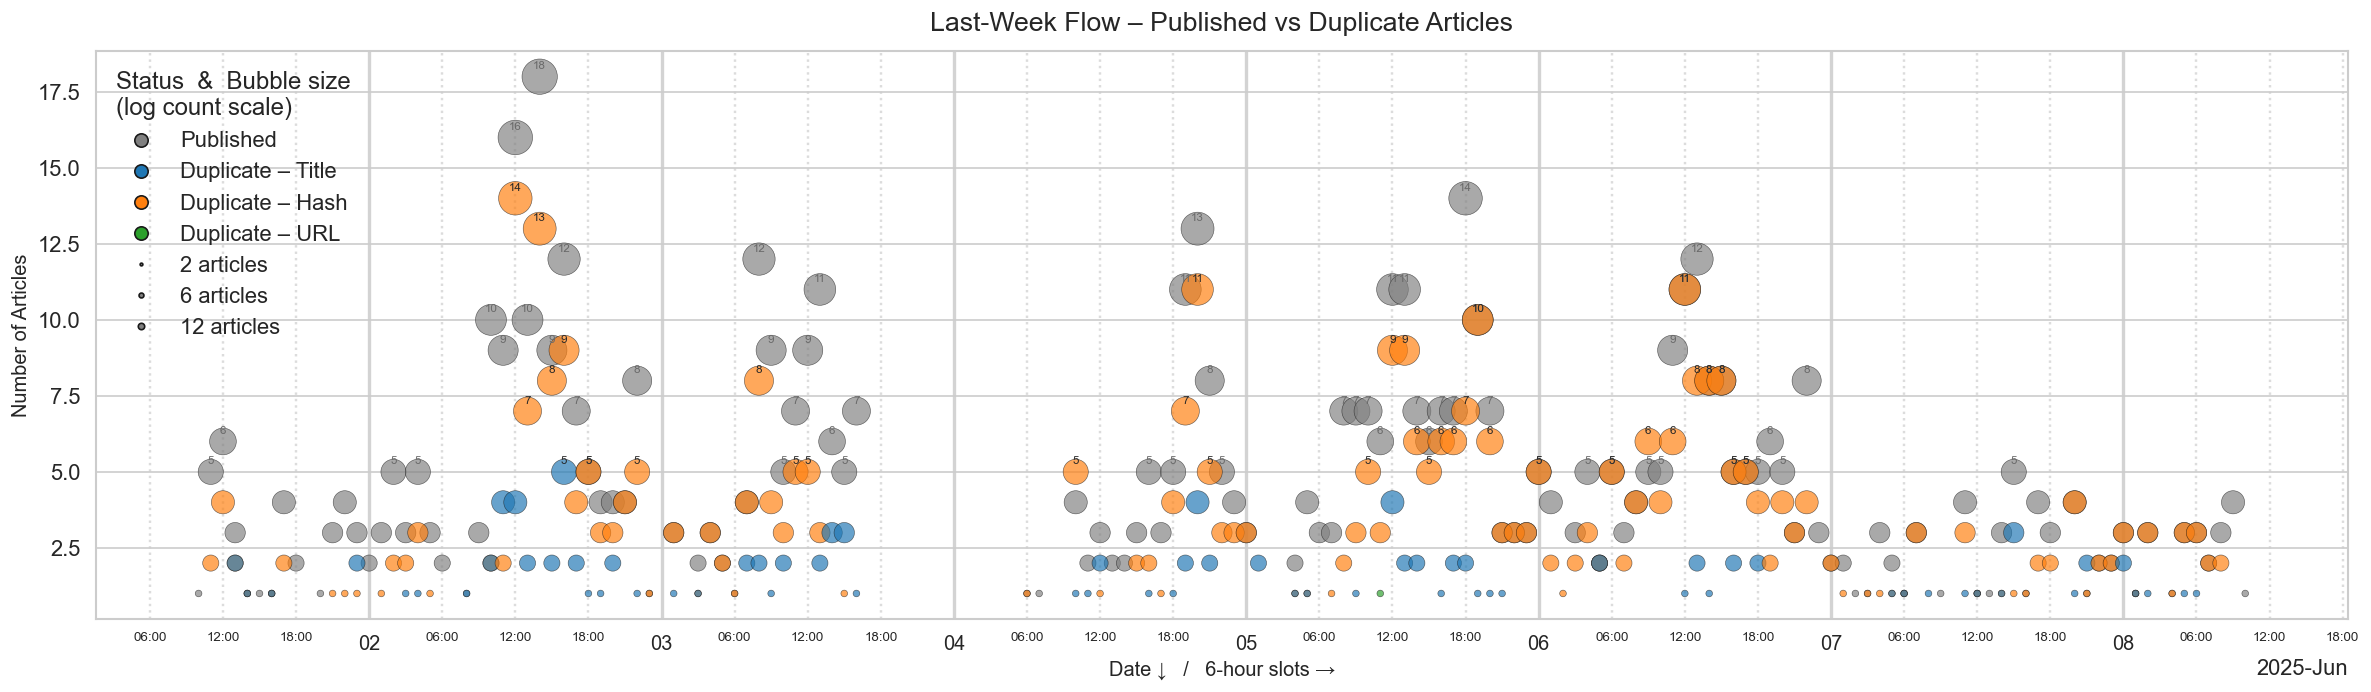

In [22]:
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

def build_hourly_tables(
        posted_df : pd.DataFrame,
        skipped_df: pd.DataFrame,
        window_days : int = 7,
        scale       : int = 6
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
   
    for df in (posted_df, skipped_df):
        df['pub_hour'] = ( pd.to_datetime(
                df['published_date'].astype(str) + ' ' +df['published_time'].astype(str),errors='coerce').dt.floor('h'))

    end = max(posted_df['pub_hour'].max(), skipped_df['pub_hour'].max())
    start = end - pd.Timedelta(days=7)
    
    pw = posted_df.loc[(posted_df['pub_hour'] >= start) & (posted_df['pub_hour'] <= end)].copy()

    duplicate_reasons = [
        'Duplicate by title',
        'Duplicate by summary hash',
        'Duplicate by url']

    sw = (skipped_df.loc[(skipped_df['pub_hour'] >= start) & (skipped_df['pub_hour'] <= end)]
        .loc[skipped_df['reason'].isin(duplicate_reasons)].copy())

    posted_hourly = (pw.groupby('pub_hour').size().reset_index(name='count').assign(reason='Published'))

    skipped_hourly = (sw.groupby(['pub_hour', 'reason']).size().reset_index(name='count'))

    for gdf in (posted_hourly, skipped_hourly):
        gdf['bubble_size'] = np.log1p(gdf['count']) * scale

    plot_df = pd.concat([posted_hourly, skipped_hourly], ignore_index=True) \
               [['pub_hour', 'count', 'reason', 'bubble_size']]

    
    return plot_df, posted_hourly, skipped_hourly

def plot_hourly_flow(
        plot_df       : pd.DataFrame,
        posted_hourly : pd.DataFrame,
        skipped_hourly: pd.DataFrame) -> None:

    class DateFmt(mdates.ConciseDateFormatter):
        def format_tick(self, x, _):
            return mdates.num2date(x).strftime('%d.%m') 
            
    class HourFmt(mdates.ConciseDateFormatter):
        def format_tick(self, x, _):
            return mdates.num2date(x).strftime('%H:%M') 

    major = mdates.DayLocator()
    minor = mdates.HourLocator(byhour=[0, 6, 12, 18]) 

    palette = {
        'Published'                 : 'grey',
        'Duplicate by title'        : 'tab:blue',
        'Duplicate by summary hash' : 'tab:orange',
        'Duplicate by url'          : 'tab:green'}

    sns.set_theme(style="whitegrid", font_scale=1.2) 
    fig, ax = plt.subplots(figsize=(20, 6), dpi=120) 

    
    sns.scatterplot(
        data=plot_df,
        x='pub_hour', y='count',
        hue='reason', size='bubble_size',
        palette=palette, sizes=(16, 450),
        edgecolor='k', linewidth=.35, alpha=.68, ax=ax)

    
    for _, r in posted_hourly[posted_hourly['count'] >= 5].iterrows():
        ax.text(r['pub_hour'], 
                r['count'] + .25, 
                r['count'],ha='center',
                fontsize=7, color='dimgray') 
        
    for _, r in skipped_hourly[skipped_hourly['count'] >= 5].iterrows(): 
        ax.text(r['pub_hour'], r['count'] + .25, r['count'],ha='center', fontsize=7)

    
    ax.xaxis.set_major_locator(major)
    ax.xaxis.set_minor_locator(minor)
    ax.xaxis.set_major_formatter(DateFmt(major)) 
    ax.xaxis.set_minor_formatter(HourFmt(minor)) 

    ax.grid(which='major', axis='x', linestyle='-', linewidth=2, color='lightgrey') 
    ax.grid(which='minor', axis='x', linestyle=':', linewidth=1.45, color='gainsboro')

    ax.tick_params(axis='x', which='major', labelsize=12) 
    ax.tick_params(axis='x', which='minor', labelsize=8)
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center') 

    sample_n = [2, 6, 12]
    size_handles = [
        Line2D([0], [0], marker='o', linestyle='', 
               markersize=np.log1p(n) * 1.5,
               markerfacecolor='grey', markeredgecolor='k',
               label=f'{n} articles') for n in sample_n]

    status_handles = [ Line2D([0], [0], marker='o', markersize=8, linestyle='', markerfacecolor=palette[key], markeredgecolor='k', label=label)
        for key, label in [
            ('Published',                 'Published'),
            ('Duplicate by title',        'Duplicate – Title'),
            ('Duplicate by summary hash', 'Duplicate – Hash'),
            ('Duplicate by url',          'Duplicate – URL')] ]

    ax.legend(handles=status_handles + size_handles,
              title='Status  &  Bubble size\n(log count scale)',
              frameon=False, 
              loc='upper left')

    ax.set_title('Last-Week Flow – Published vs Duplicate Articles', fontsize=16, pad=12)
    ax.set_xlabel('Date ↓   /   6-hour slots →', fontsize=12)
    ax.set_ylabel('Number of Articles', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_df, posted_hourly, skipped_hourly = build_hourly_tables(posted_df, skipped_df)
plot_hourly_flow(plot_df, posted_hourly, skipped_hourly)


# 🔹Step 4: Topic Clustering & Trend Analysis
In this step we embed articles into vectors, cluster them by semantic similarity, compute cluster summaries and examples, plot each topic’s publication trends, and analyze the split between unique and duplicate articles.

#### Part 1: Combine each article’s title and summary into a single super_text field, load the paraphrase-MiniLM-L6-v2 transformer model, and encode all super_text entries into numerical embedding vectors for downstream clustering.

In [23]:
from sklearn.cluster import DBSCAN

posted_df['super_text'] = posted_df['title'].astype(str) + " " + posted_df['summary'].astype(str)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Convert each article into a numerical embedding vector representing its content
embeddings = model.encode(posted_df['super_text'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

#### Part 2: Apply DBSCAN clustering (eps=0.19, min_samples=2, cosine metric) on the embeddings, assign each article a topic_id (or –1 for noise), count the number of real clusters and noise points, and print a summary of detected topics and noise articles.

In [24]:
# 2. Apply DBSCAN on the embeddings
# eps: radius around each point – how close points need to be to be considered neighbors
# min_samples=2: minimum number of neighbors required to form a cluster
# metric='cosine': measure distance between embeddings using cosine distance
db = DBSCAN(eps=0.19, min_samples=2, metric='cosine')
labels = db.fit_predict(embeddings)  # labels – each article’s cluster ID (integer), or -1 if it’s noise
posted_df['topic_id'] = labels       # add a new column to the DataFrame with cluster IDs (or -1 for noise)

# 3. Count clusters and noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # compute the number of real clusters (exclude -1 for noise)
n_noise = (labels == -1).sum()                             # count how many articles weren’t assigned to any cluster
print(f"\nDBSCAN: Found {n_clusters} topics (clusters) and {n_noise} noise articles (not assigned to any topic).\n")  # summary printout



DBSCAN: Found 310 topics (clusters) and 3793 noise articles (not assigned to any topic).



#### Part 3: Calculate for each article how many peers share its topic_id (excluding noise), then filter out noise articles and select the top five clusters with at least five articles each.

In [25]:
# Compute similar_articles and similar_count based on topic_id
def get_similar_articles(idx, topic_id, labels):
    if topic_id == -1:
        return []
    # Find all articles with the same topic_id (excluding itself)
    indices = np.where(labels == topic_id)[0]  # Find all indices of articles in the same cluster
    # Return the indices of similar articles (excluding itself)
    return [int(i) for i in indices if i != idx]

posted_df['similar_count'] = (
    posted_df.groupby('topic_id')['topic_id']        # For each topic, get the series of topic IDs
             .transform('size')                      # Repeat cluster size for each row
             .sub(1)                                 # Exclude the article itself
             .where(posted_df['topic_id'] != -1, 0)  # Assign 0 for noise articles
)

# Create DataFrame of only significant topics (e.g., with 5 or more articles)
topic_df = posted_df[posted_df['topic_id'] != -1].copy()  # Filter to include only clustered articles (exclude noise)
topic_df['topic_id'] = topic_df['topic_id'].astype(int)   # Convert cluster IDs to integers
topic_sizes = topic_df['topic_id'].value_counts()        # Count how many articles are in each cluster
# Select the top 5 largest clusters (at least 5 articles each)
large_topics = topic_sizes[topic_sizes >= 5].index.tolist()
print(f"Selected the top 5 strongest topics (out of {sum(topic_sizes >= 5)} topics with at least 5 articles)")


Selected the top 5 strongest topics (out of 43 topics with at least 5 articles)


#### Part 4: Aggregating & Displaying Strong Topic Summaries
Group the five largest clusters to compute per-topic stats (article count, first/last dates, main country, article IDs) and then print example articles for each topic—showing date, source, and a snippet of the title.

In [26]:
# --- Build an aggregated summary for the “strong” topics only ----------------
agg_df = (
    # Keep rows whose topic_id is in the list large_topics
    topic_df.loc[topic_df['topic_id'].isin(large_topics)]
            # Group by topic_id – everything that follows runs per-topic
            .groupby('topic_id')
            # Aggregate several statistics for each topic
            .agg(
                num_articles=('topic_id', 'size'),                 # how many articles in the topic
                first_date   =('published_date', 'min'),          # earliest publication date
                last_date    =('published_date', 'max'),          # latest  publication date
                main_country =('rss_source',
                               lambda x: x.mode()[0]),            # most frequent country (rss_source)
                article_ids  =('topic_id',
                               lambda x: x.index.tolist())         # list of article indices belonging to the topic
            )
            # Put topic_id back as a normal column instead of an index
            .reset_index()
)

# --- Final summary table: keep only the rows whose topic_id appears in large_topics
#     (strictly redundant here because agg_df already contains only those IDs,
#      but it is a safe guard if large_topics is modified later).
topic_summary = agg_df.loc[agg_df['topic_id'].isin(large_topics)]


In [27]:
print("\n=== Examples of topics with at least 5 articles ===")
for topic in large_topics: 
    subset = topic_df[topic_df['topic_id'] == topic].sort_values('published_date')
    print(f"\n Topic ID: {topic} - {len(subset)} articles")
    for _, row in subset.iterrows():
        print(f"  - {row['published_date'].date()} | {row['rss_source']} | {row['title'][:95]}.")


=== Examples of topics with at least 5 articles ===

 Topic ID: 7 - 87 articles
  - 2025-04-24 | United States | M&S takes systems offline as 'cyber incident' lingers - The Register.
  - 2025-04-24 | United States | M&S struggles to get on top of 'cyber incident' - The Irish Times.
  - 2025-04-24 | United States | M&S systems remain offline days after cyber incident - Computer Weekly.
  - 2025-04-25 | United States | M&S cyberattack: online orders suspended after week of disruption - The Times.
  - 2025-04-25 | England | M&S suspends online orders after cyber incident - Sharecast.com.
  - 2025-04-25 | England | M&S halts all online orders amid ongoing disruption caused by cyber attack - ITVX.
  - 2025-04-25 | United States | M&S halts online orders as 'cyber incident' gets worse - The Register.
  - 2025-04-25 | England | M&S pauses online and app orders following cyber attack - The Herald.
  - 2025-04-25 | England | Marks and Spencer pauses online orders after reported hacking inciden

#### Part 5: For each of the top topics, count articles per day, compute a 2-day rolling average, and plot both the actual daily counts and the moving average to visualize each topic’s publication trend over time.

Plotting trends for these 5 topics: [7, 82, 251, 75, 73]


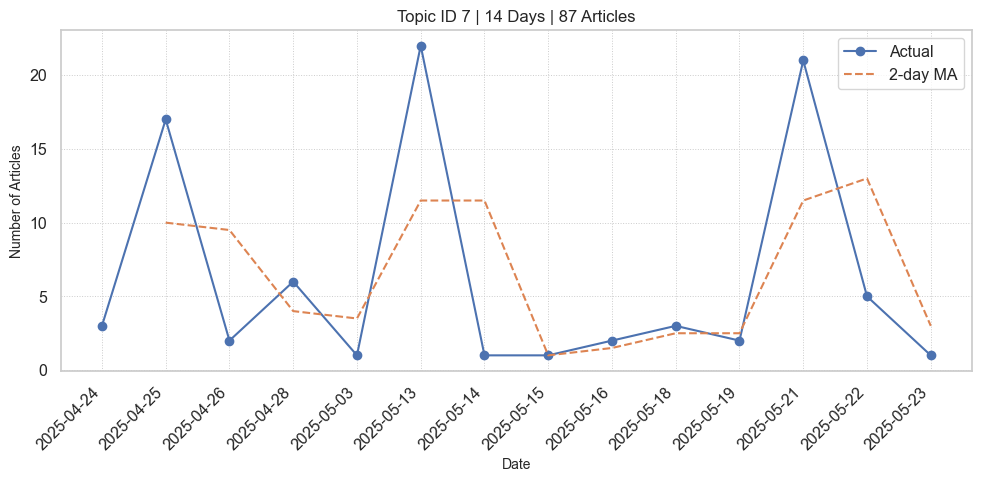

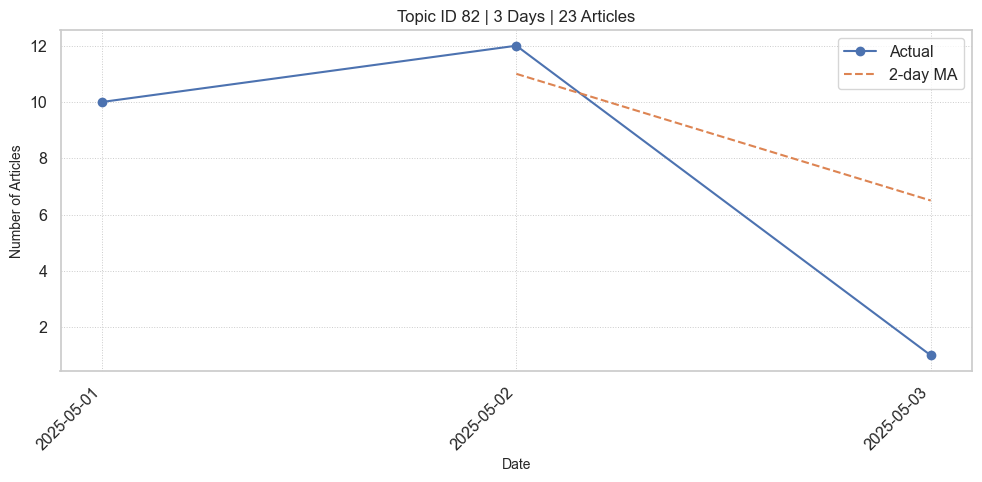

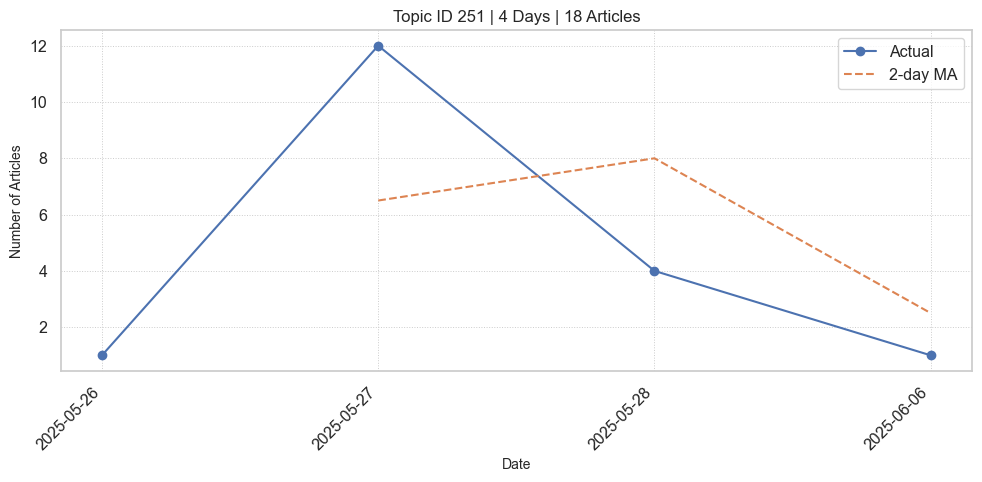

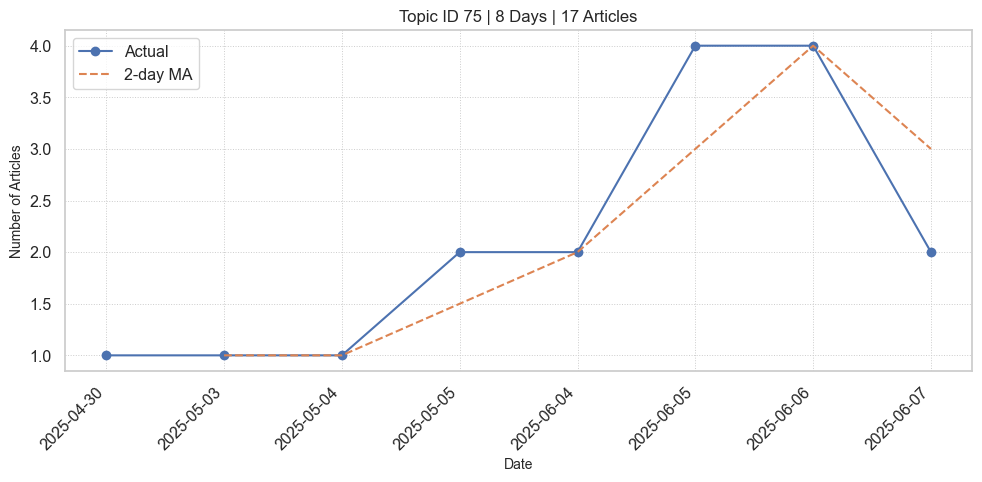

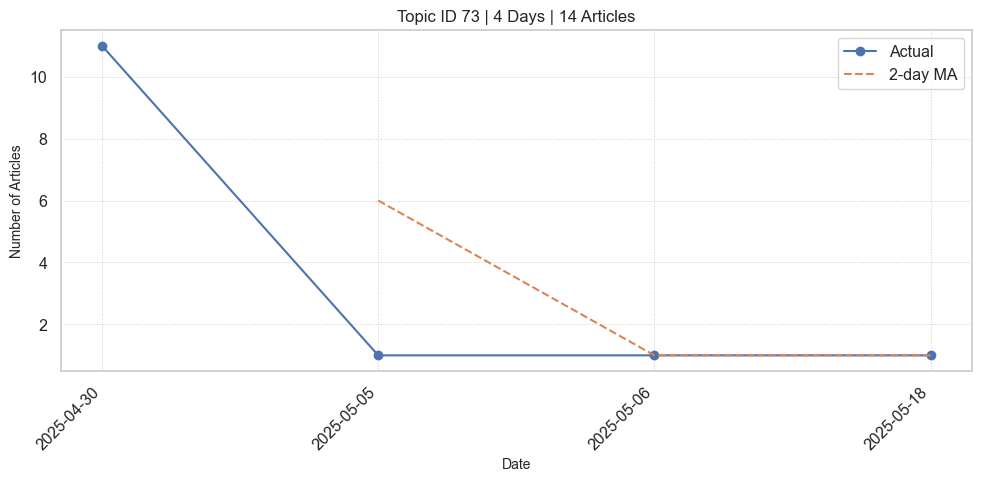

In [43]:
topic_sizes  = topic_df['topic_id'].value_counts()
large_topics = [t for t, sz in topic_sizes.items() if sz >= 5]

# 2️⃣ מתוך אלה – השאר רק מי שמתפרס על לפחות 3 ימים שונים
eligible = [
    t for t in large_topics
    if topic_df.loc[topic_df['topic_id']==t, 'published_date'].nunique() >= 3
]

# 3️⃣ מיין את ה־eligible לפי גודל אשכול (יורד) ובחר 5 ראשונים
eligible.sort(key=lambda t: topic_sizes[t], reverse=True)
top5_topics = eligible[:5]
print("Plotting trends for these 5 topics:", top5_topics)

# 4️⃣ לולאת השרטוט – עבור כל אחד מה־top5
for topic in top5_topics:
    subset      = topic_df[topic_df['topic_id'] == topic]
    # 4.1 ספירת כתבות לפי יום, ממוינת כרונולוגית
    topic_dates = subset['published_date'].value_counts().sort_index()
    # 4.2 ממוצע נע בן יומיים
    ma          = topic_dates.rolling(window=2).mean()

    # הפיכת אינדקסי התאריכים למחרוזות 'YYYY-MM-DD' להצגה על הציר
    dates      = topic_dates.index.strftime('%Y-%m-%d')
    ma_dates   = ma.index.strftime('%Y-%m-%d')

    # 4.3 יצירת הגרף
    plt.figure(figsize=(10, 5))
    plt.plot(  dates,      topic_dates.values, marker='o', label='Actual')
    plt.plot( ma_dates,    ma.values,          linestyle='--', label='2-day MA')
    plt.title(f"Topic ID {topic} | {len(topic_dates)} Days | {len(subset)} Articles", fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Number of Articles", fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.tight_layout()
    plt.show()

#### Part 6: Calculate how many articles have zero similar peers versus those with duplicates, then plot a bar chart of “Unique (0)” vs. “With duplicates (>0)” with annotated percentages and raw counts.

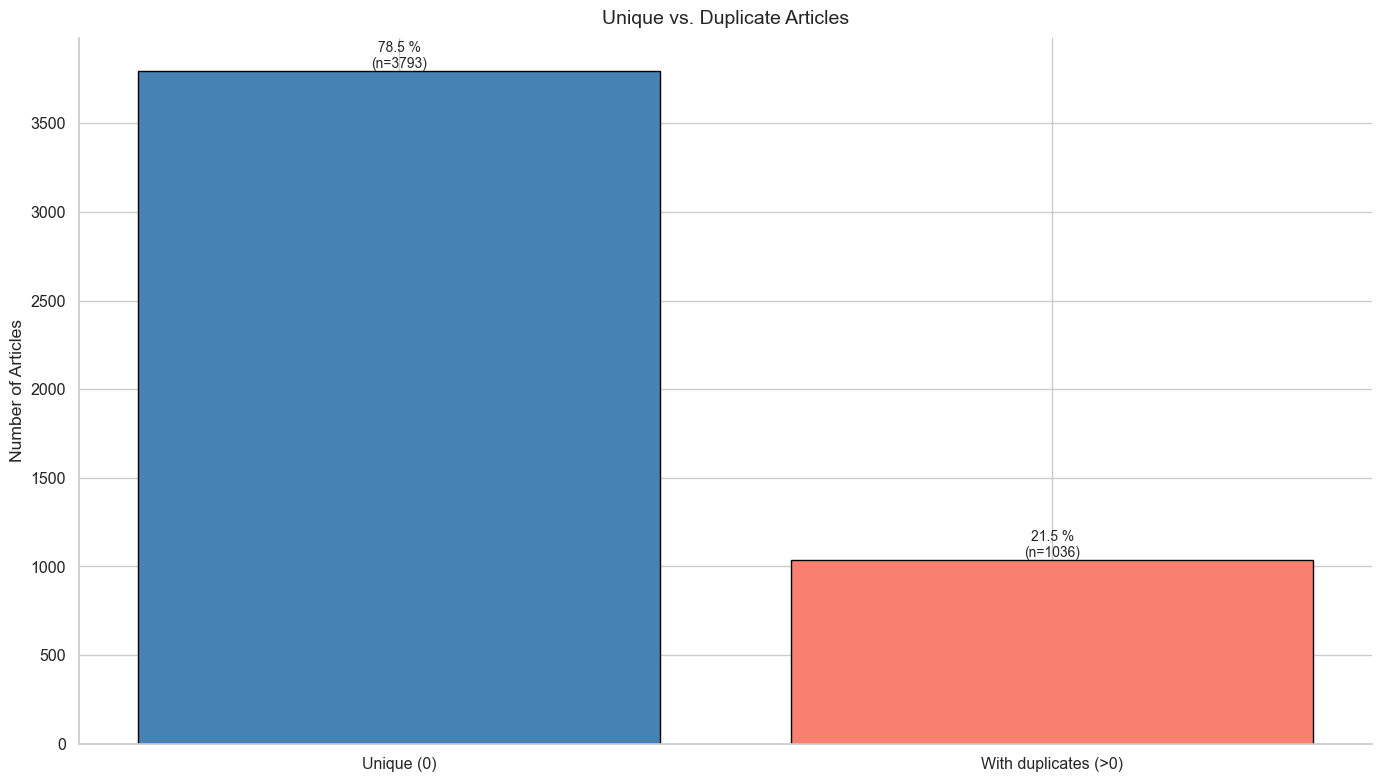

In [44]:
counts = posted_df['similar_count'].eq(0).value_counts().rename(index={True: 'Unique (0)', False: 'With duplicates (>0)'})
percent = (counts / counts.sum() * 100).round(1)

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(counts.index, counts.values, color=['steelblue', 'salmon'], edgecolor='black')

for bar, pct, n in zip(bars, percent, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{pct} %\n(n={n})', ha='center', va='bottom', fontsize=10)

ax.set_title('Unique vs. Duplicate Articles', fontsize=14, pad=10)
ax.set_ylabel('Number of Articles')
sns.despine(); plt.tight_layout(); plt.show()


# 🔹Step 5: Aggregating Topic Summaries and Engineering Trend Features
In this step we consolidate all clusters into the central topics_df, compute and map key trend metrics (num_days, max_articles_per_day, spike_detected, growth_detected), classify each topic’s overall trend_type (Spike/Growth/Both/None), and determine the dominant publication day for every topic.











#### Part 1: Build a central topics_df by aggregating each cluster’s metadata—count of articles, first/last dates, primary country, top 5 keywords, and a representative short title.

In [30]:
topics_df = (
    topic_df.sort_values('published_date').groupby('topic_id').agg(
    num_articles=('ID', 'count'),  
    first_date=('published_date', 'min'), 
    last_date=('published_date', 'max'),  
    main_country=('rss_source', lambda x: x.mode()[0] if not x.mode().empty else None), 
    top_keywords=('cleaned_keywords', lambda x: ', '.join(pd.Series([kw for kws in x for kw in kws]).value_counts().head(5).index)),
    short_title=('title', 'first')
).reset_index())

#### Part 2: Calculate trend metrics for each topic by counting distinct publication days (topic_day_counts)
finding the maximum articles in a single day (max_articles_per_day), and defining boolean flags for spike events (≥4 articles/day) and growth phases (presence on ≥3 different days).

In [31]:
topic_day_counts = topic_df.groupby('topic_id')['published_date'].nunique() 

max_articles_per_day = (topic_df.groupby(['topic_id', 'published_date']).size().groupby('topic_id').max()) 

spike_condition = max_articles_per_day >= 4     
growth_condition = topic_day_counts >= 3        

#### Part 3: Map each topic’s trend metrics into topics_df—adding num_days, max_articles_per_day, spike_detected, and growth_detected columns by looking up the precomputed conditions via topic_id.










In [32]:
topics_df['num_days'] = topics_df['topic_id'].map(topic_day_counts)
topics_df['max_articles_per_day'] = topics_df['topic_id'].map(max_articles_per_day)
topics_df['spike_detected'] = topics_df['topic_id'].map(spike_condition) 
topics_df['growth_detected'] = topics_df['topic_id'].map(growth_condition) 


#### Part 4: Topic Summary & Trend Feature Engineering
Aggregate all clusters into topics_df, compute and map trend metrics (num_days, max_articles_per_day, spike_detected, growth_detected), classify each topic’s trend_type (Spike/Growth/Both/None), and determine the dominant publication day per topic.

In [33]:
def classify_trend(spike, growth):
    if spike and growth:
        return 'Both'
    elif spike:
        return 'Spike'
    elif growth:
        return 'Growth'
    else:
        return 'None'

topics_df['trend_type'] = topics_df.apply(
    lambda row: classify_trend(row['spike_detected'], row['growth_detected']),
    axis=1
)

dominant_day = (topic_df.groupby(['topic_id', 'published_date']).size()
                        .groupby('topic_id').idxmax()  
                        .apply(lambda x: x[1])) 

topics_df['dominant_day'] = topics_df['topic_id'].map(dominant_day) 


# 🔹Step 6: Finalize Summaries & Persist to Database
Consolidate the final topic summary table and then insert any new topic, article, and trend records into their respective database tables.

#### Part 1: Select and reorder the final columns in topics_df—focusing on key summary and trend fields—and display the first few rows to confirm the table structure.

In [34]:
topics_df = topics_df[[
    'topic_id', 'short_title', 'trend_type',
    'num_articles', 'num_days', 'max_articles_per_day',
    'first_date', 'dominant_day', 'last_date', 'main_country',
    'top_keywords', 'spike_detected', 'growth_detected']]

print(topics_df.head())

   topic_id                                        short_title trend_type  \
0         0  FBI: Cybercrime cost victims 'staggering' $16....       None   
1         1  Thales and Deloitte align to offer advanced cy...       None   
2         2  TOKYO, Apr 24, 2025 - NEC Corporation (NEC; TS...       None   
3         3  Not just any cyber incident...but an M&S cyber...     Growth   
4         4  Benchmarking Standard for Securing AI Systems ...       None   

   num_articles  num_days  max_articles_per_day first_date dominant_day  \
0             3         2                     2 2025-04-24   2025-04-24   
1             2         2                     1 2025-04-23   2025-04-23   
2             2         2                     1 2025-04-24   2025-04-24   
3             3         3                     1 2025-04-23   2025-04-23   
4             2         2                     1 2025-04-23   2025-04-23   

   last_date   main_country  \
0 2025-04-28  United States   
1 2025-04-25  United Sta

#### Part 2: Save New Topics to the Database
Load existing topic IDs, filter out those already stored, and append any new topic summaries from topics_df into the Topics table.

In [35]:
existing_topics = pd.read_sql("SELECT topic_id FROM Topics", con=engine)
topics_df_filtered = topics_df[~topics_df['topic_id'].isin(existing_topics['topic_id'])]

if not topics_df_filtered.empty:  # If there are new topics to insert
    topics_df_filtered.to_sql('Topics', con=engine, index=False, if_exists='append')
    print(f"✅ Topics saved: {len(topics_df_filtered)}") 
else:
    print("ℹ️ No new topics to insert.") 

✅ Topics saved: 310


#### Part 3: Prepare and Save Articles
Select key columns from topic_df (renaming ID to article_id and serializing keywords), filter out articles already in the Articles table, and insert new records.

In [36]:
articles_df = topic_df[[
    'ID', 'title', 'summary', 'url',
    'published_date', 'published_time', 'rss_source',
    'cleaned_keywords','topic_id', 'similar_count']].copy()

articles_df.rename(columns={'ID': 'article_id'}, inplace=True) 
articles_df['cleaned_keywords'] = articles_df['cleaned_keywords'].apply(lambda kws: ', '.join(kws) if isinstance(kws, list) else '') 
print(articles_df[["title","published_date"]].sort_values('published_date', ascending = False).head())


existing_articles = pd.read_sql("SELECT article_id FROM Articles", con=engine) 
articles_df_filtered = articles_df[~articles_df['article_id'].isin(existing_articles['article_id'])]  

if not articles_df_filtered.empty: 
    articles_df_filtered.to_sql('Articles', con=engine, index=False, if_exists='append')  
    print(f"✅ Articles saved: {len(articles_df_filtered)}")
else:
    print("ℹ️ No new articles to insert.") 

                                                  title published_date
4824  Trump Targets Obama-Biden Cyber Policies in Ne...     2025-06-08
4820  North Korea wiped off the internet for 9 hours...     2025-06-08
4814  Cyber Police Kashmir Issues Stern Warning Agai...     2025-06-08
4806  Trump Signs Order Amending Parts of Biden, Oba...     2025-06-08
4796  The EU's Cybersecurity Blueprint and the Futur...     2025-06-08
✅ Articles saved: 1036


#### Part 4: Prepare and Save Trends
Filter topics_df for non-None trends, map each trend to a representative article summary, exclude already saved entries in Trends, and append the new trend records.

In [37]:
trends_df = topics_df[topics_df['trend_type'] != 'None'].copy() 

topic_summary_map = ( 
    articles_df
    .sort_values(['topic_id', 'published_date'], ascending=[True, True]) 
    .drop_duplicates('topic_id') 
    .set_index('topic_id')['summary']
)

trends_df['representative_summary'] = trends_df['topic_id'].map(topic_summary_map) 

print(trends_df[["short_title","trend_type","first_date"]].head())

existing_trends = pd.read_sql("SELECT topic_id FROM Trends", con=engine) 
trends_df_filtered = trends_df[~trends_df['topic_id'].isin(existing_trends['topic_id'])] 

if not trends_df_filtered.empty:
    trends_df_filtered.to_sql('Trends', con=engine, index=False, if_exists='append')
    print(f"✅ Trends saved: {len(trends_df_filtered)}")
else:
    print("ℹ️ No new trends to insert.") 


                                          short_title trend_type first_date
3   Not just any cyber incident...but an M&S cyber...     Growth 2025-04-23
7   M&S takes systems offline as 'cyber incident' ...       Both 2025-04-24
8   M&S: Shares at FTSE 100 retailer fall as cyber...     Growth 2025-04-24
12  CISA Releases Seven Industrial Control Systems...     Growth 2025-04-24
19  MTN Group experiences a cyber security obstacl...     Growth 2025-04-25
✅ Trends saved: 62


# 🔸 Step 7: Visualizing Top Cyber Trends
In this step we present four complementary charts to explore trending topics: a bar chart of the top 10 topics by article volume, multi‐line daily publication trends with shaded areas and peak annotations, a word cloud of the most frequent trend keywords, and a detailed horizontal bar chart of the top seven trends annotated with summaries, dates, and key metadata.

#### 🔸Graph 1: Select & Visualize Top 10 Trending Topics
Sort the trends_df by article count and active days to pick the top 10 topics, map their IDs to short titles, and plot a bar chart of article counts for each leading topic.


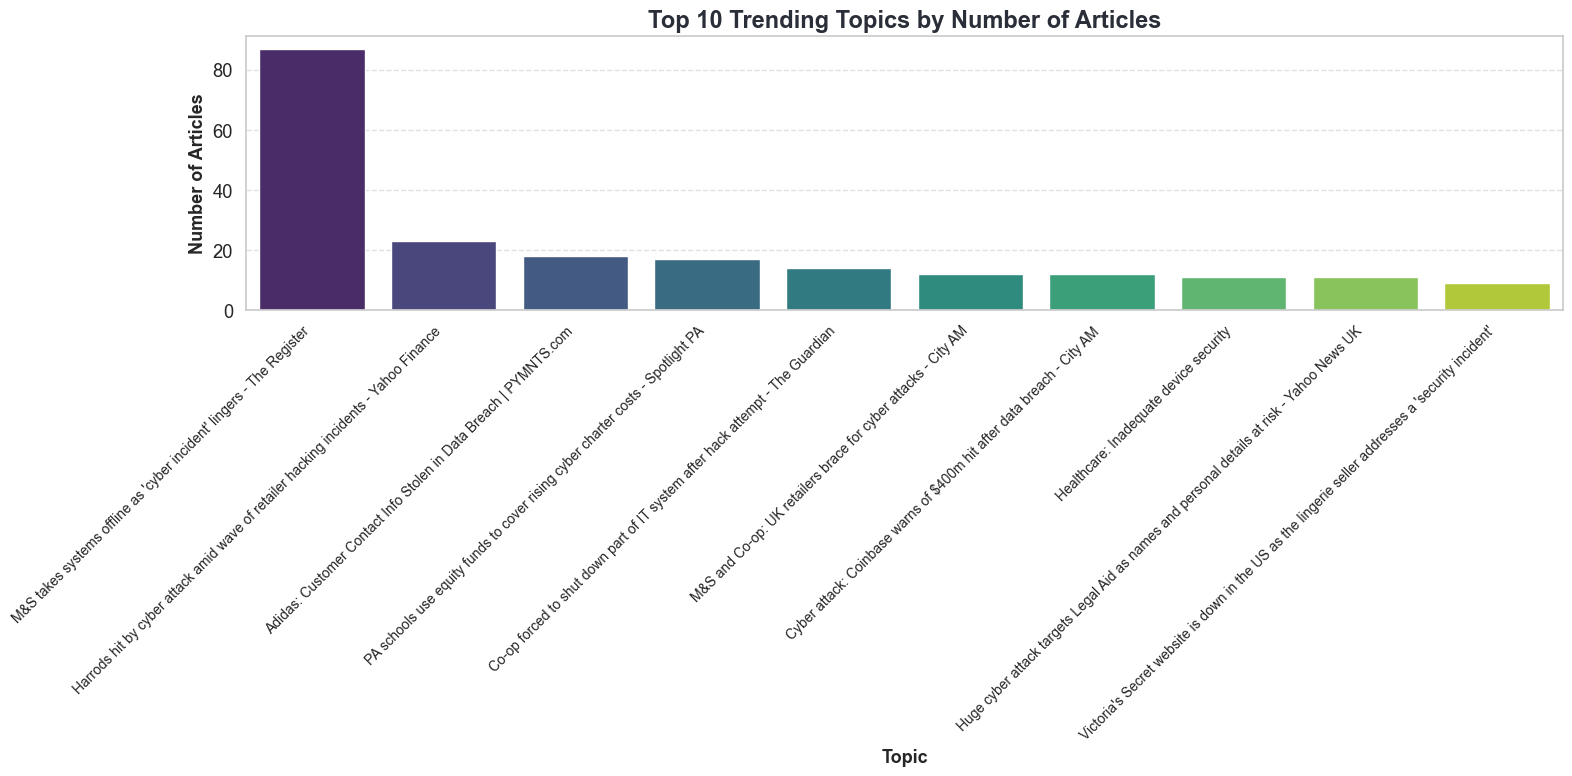

In [38]:
top_trends = trends_df.sort_values(['num_articles', 'num_days'], ascending=False).head(10 )
top_topic_ids = top_trends['topic_id'].tolist()
id_to_title = dict(zip(top_trends['topic_id'], top_trends['short_title']))

plt.figure(figsize=(16, 8))
sns.barplot(
    data=top_trends, 
    x='short_title',
    y='num_articles',
    hue='short_title',
    palette='viridis',
    legend=False
)
plt.title('Top 10 Trending Topics by Number of Articles', fontsize=17, fontweight='bold', color='#2a2e38')
plt.xlabel('Topic', fontsize=13, fontweight='bold')
plt.ylabel('Number of Articles', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)# plt.grid(axis='y')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### 🔸Graph 2: Plot Daily Publication Trends for Top Trending Topics
Compute daily article counts for each of the top trending topics, assign a distinct color to each, and draw a multi‐line chart with shaded areas under each line and annotations at peaks (counts ≥10) to highlight publication dynamics over time.


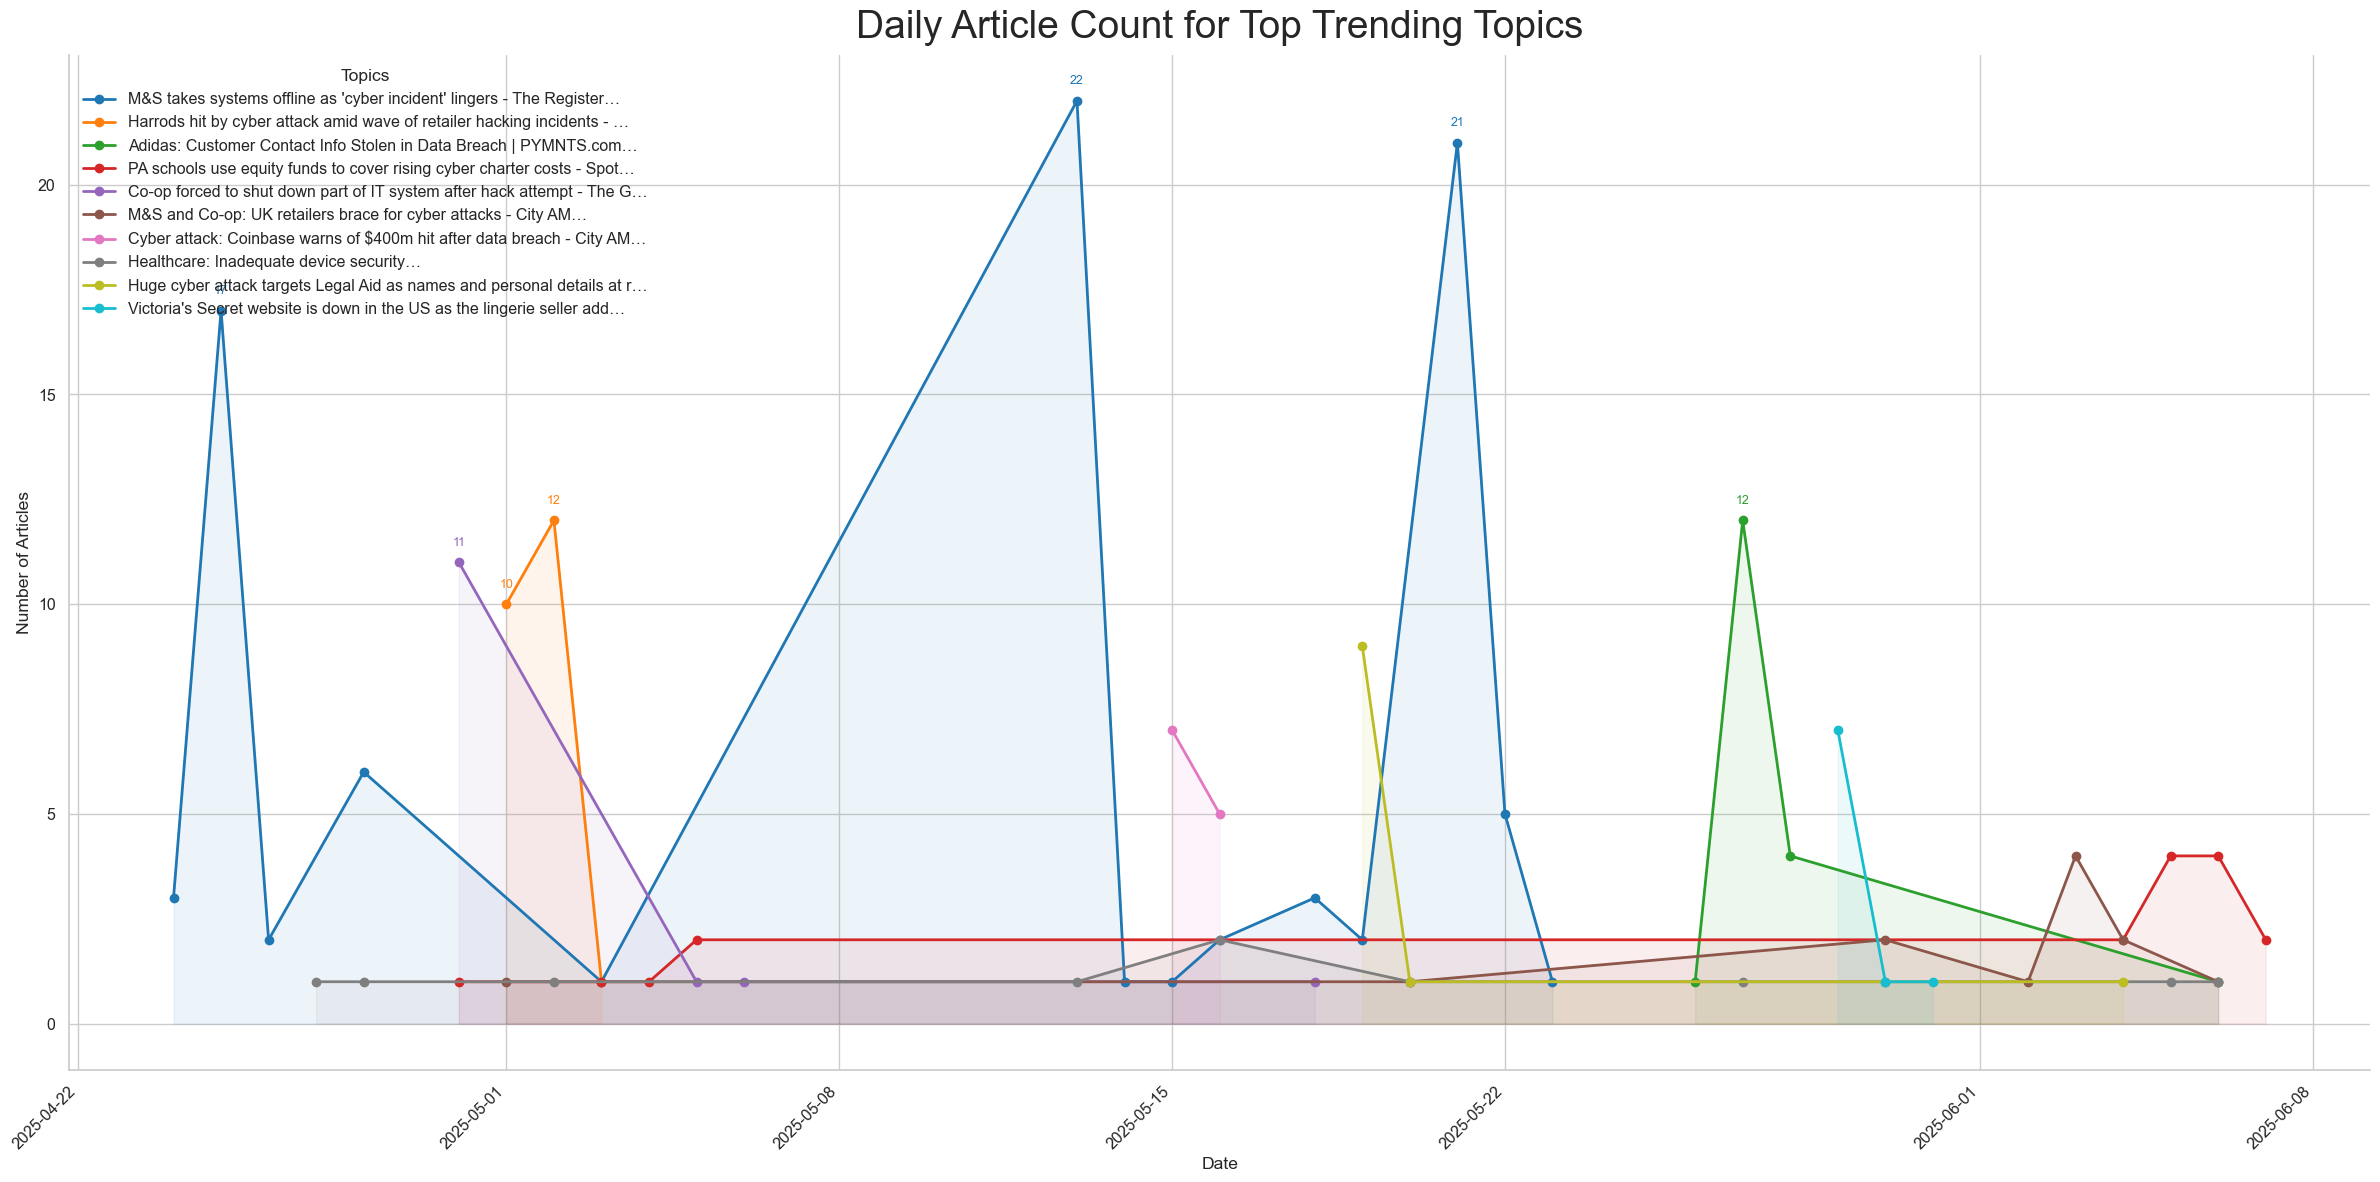

In [39]:

sns.set_theme(style="whitegrid", font_scale=1.05)
mask = topic_df['topic_id'].isin(top_topic_ids)
daily_counts = (topic_df.loc[mask]
                .groupby(['topic_id', 'published_date'])
                .size()
                .reset_index(name='count')
                .merge(topics_df[['topic_id', 'short_title']], on='topic_id'))

daily_counts = daily_counts.sort_values('published_date')


palette = sns.color_palette('tab10', n_colors=len(top_topic_ids))
colours = {tid: palette[i] for i, tid in enumerate(top_topic_ids)}


fig, ax = plt.subplots(figsize=(24, 12))

for tid in top_topic_ids:
    sub = daily_counts[daily_counts['topic_id'] == tid]

    ax.plot(sub['published_date'], sub['count'],
        marker='o', linewidth=2, color=colours[tid], label=sub['short_title'].iloc[0][:70] + '…')

    ax.fill_between(sub['published_date'],
                sub['count'], color=colours[tid], alpha=.08)

    for x, y in zip(sub['published_date'], sub['count']):
        if y >= 10:
            ax.text(x, y + 0.4, f'{y}', ha='center',
                    fontsize=9, color=colours[tid])

ax.set_title('Daily Article Count for Top Trending Topics', fontsize=28, pad=12)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Articles')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Topics', frameon=False, loc='upper left')
sns.despine()
plt.tight_layout()
plt.show()


#### 🔸Graph 3: Word Cloud of Trending Topic Keywords
Combine all top keywords from the trending topics into a single text blob and generate a word cloud to visually highlight the most frequent keywords driving current trends.

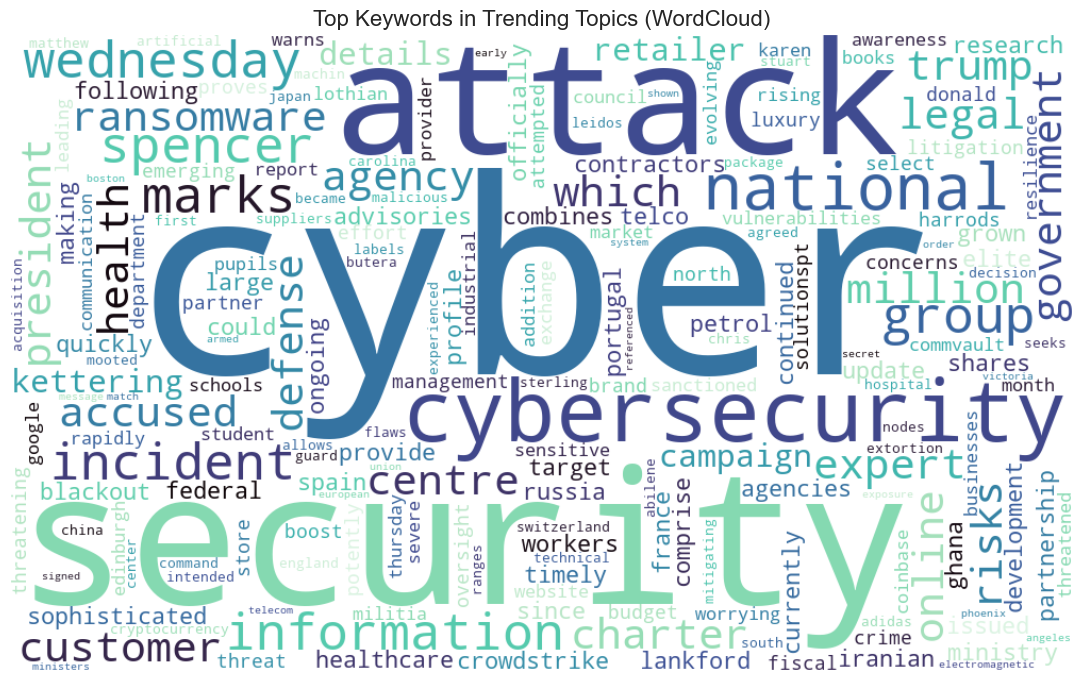

In [40]:
trend_keywords_series = trends_df['top_keywords'].dropna().astype(str)
text_blob = ' '.join(trend_keywords_series)

wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='mako',contour_width=2,
    contour_color='steelblue',stopwords=stopwords).generate(text_blob)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Trending Topics (WordCloud)', fontsize=16)
plt.tight_layout()
plt.show()


#### 🔸Graph 4: Visualize Top 7 Trends with Detailed Summaries
For the seven leading topics, we wrap each representative summary, extract its top keywords, and plot a horizontal bar chart of article counts—annotating each bar with trend metadata, dominant day, country, and keyword details for quick interpretation.


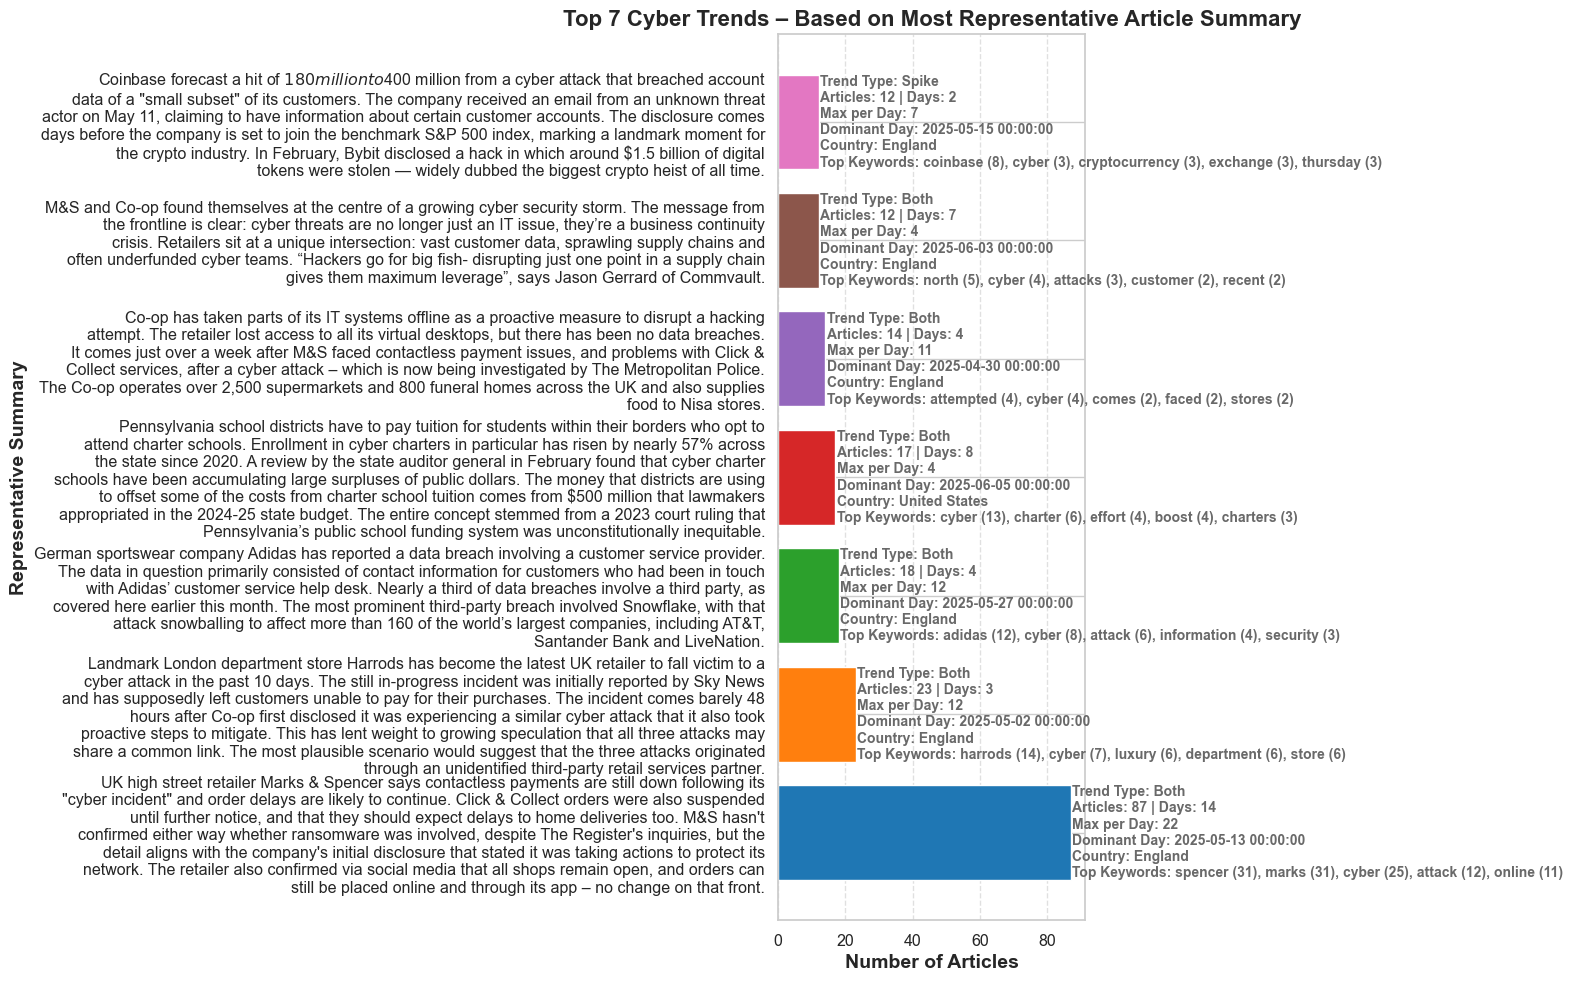

In [41]:
top_topic_ids = trends_df.sort_values(['num_articles', 'num_days'], ascending=False).head(7)['topic_id']
top_articles = articles_df[articles_df['topic_id'].isin(top_topic_ids)].copy()
if isinstance(top_articles['cleaned_keywords'].iloc[0], list):
    top_articles['cleaned_keywords'] = top_articles['cleaned_keywords'].apply(lambda x: ' '.join(x))

topic_keywords = top_articles.groupby('topic_id')['cleaned_keywords'].apply(lambda x: ' '.join(x))
vec = CountVectorizer()
X = vec.fit_transform(topic_keywords)
keyword_matrix = pd.DataFrame(X.toarray(), index=topic_keywords.index, columns=vec.get_feature_names_out())

def get_top5_keywords(row):
    topic_id = row['topic_id']
    if topic_id in keyword_matrix.index:
        top_words = keyword_matrix.loc[topic_id].sort_values(ascending=False).head(5)
        top_words = top_words[top_words > 0]
        return ', '.join([f"{word} ({count})" for word, count in top_words.items()])
    else:
        return "N/A"

def wrap_summary(text, max_len=100, max_lines=7):
    words = text.split()
    lines = []
    line = ""
    for word in words:
        if len(line + " " + word) <= max_len:
            line += " " + word
        else:
            lines.append(line.strip())
            line = word
            if len(lines) == max_lines:
                break
    if line and len(lines) < max_lines:
        lines.append(line.strip())
    return '\n'.join(lines)

top7 = trends_df[trends_df['topic_id'].isin(top_topic_ids)].sort_values(by=['num_articles', 'num_days'], ascending=False).copy()

top7['wrapped_title'] = top7['representative_summary'].apply(wrap_summary)
top7['top5_keywords'] = top7.apply(get_top5_keywords, axis=1)

top7['label'] = top7.apply(lambda row: (
    f"Trend Type: {row['trend_type']}\n"
    f"Articles: {row['num_articles']} | Days: {row['num_days']}\n"
    f"Max per Day: {row['max_articles_per_day']}\n"
    f"Dominant Day: {row['dominant_day']}\n"
    f"Country: {row['main_country']}\n"
    f"Top Keywords: {row['top5_keywords']}"
), axis=1)


colors = plt.cm.tab10.colors
bar_colors = [colors[i % len(colors)] for i in range(len(top7))]

fig, ax = plt.subplots(figsize=(16, 10))
bars = ax.barh(top7['wrapped_title'], top7['num_articles'], color=bar_colors)

for bar, label in zip(bars, top7['label']):
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        label,
        va='center',
        ha='left',
        fontsize=10,
        color='dimgray'
        , fontweight='bold'
    )

ax.set_title("Top 7 Cyber Trends – Based on Most Representative Article Summary", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Articles", fontsize=14, fontweight='bold')
ax.set_ylabel("Representative Summary", fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.97, 1]) 
plt.show()
